## 라이브러리

In [1]:
from glob import glob # 파일 경로

import pandas as pd # 데이터 분석
import numpy as np # 수치 계산

import time # 걸리는 시간 확인
import datetime as dt

from dask import dataframe as dd # dask 로 대용량 파일 로드
from dask.diagnostics import ProgressBar # dask progress bar

import seaborn as sns
import matplotlib.pyplot as plt
import squarify
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

## 파일 불러오기

In [2]:
file_name = sorted(glob('data/*.gzip'))
apple = pd.read_parquet(file_name[2])
brand = pd.read_parquet(file_name[3])
samsung = pd.read_parquet(file_name[4])

In [3]:
brand.shape, apple.shape, samsung.shape

((23553953, 9), (10381933, 9), (13172020, 9))

In [4]:
len(apple) + len(samsung) == len(brand)

True

In [5]:
samsung.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13172020 entries, 0 to 13172019
Data columns (total 9 columns):
 #   Column         Dtype   
---  ------         -----   
 0   event_time     object  
 1   event_type     category
 2   product_id     int64   
 3   category_id    uint64  
 4   category_code  object  
 5   brand          object  
 6   price          float32 
 7   user_id        int64   
 8   user_session   object  
dtypes: category(1), float32(1), int64(2), object(4), uint64(1)
memory usage: 766.3+ MB


### 중복 제거

In [6]:
samsung = samsung.drop_duplicates(keep='first')
samsung.shape

(13135262, 9)

### 결측치 확인

In [7]:
samsung.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    279636
brand                 0
price                 0
user_id               0
user_session          2
dtype: int64

### 날짜 형식 변환

In [8]:
# datetime으로
samsung['event_time'] = pd.to_datetime(samsung['event_time'].str[:-4])
samsung['event_time'].head(1)

0   2019-10-01 00:00:11
Name: event_time, dtype: datetime64[ns]

In [9]:
n_samsung = samsung.copy()

In [10]:
# 월, 일, 월일 파생변수 생성
n_samsung['month'] = n_samsung['event_time'].dt.month #월
n_samsung['day'] = n_samsung['event_time'].dt.day #일
n_samsung['md'] = n_samsung['event_time'].astype(str).str[5:10] #월일
n_samsung.tail(1)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month,day,md
13172019,2019-11-30 23:59:59,view,2701706,2053013563911439225,appliances.kitchen.refrigerators,samsung,566.27002,531607492,368ddc8b-5db9-40fb-b7ff-b6582a1192c0,11,30,11-30


## 변수 살펴보기

In [11]:
# user 수
s_user = samsung['user_id'].nunique()
s_user 

1830557

In [12]:
# product 수
s_product = samsung['product_id'].nunique()
s_product

1227

In [13]:
# event 수
s_events = samsung['event_type'].value_counts()
s_events

view        11898032
cart          864326
purchase      372904
Name: event_type, dtype: int64

In [14]:
categories = samsung['category_code'].value_counts()
categories

electronics.smartphone                    9065552
electronics.video.tv                      1160847
appliances.kitchen.washer                  687260
appliances.environment.vacuum              574981
electronics.clocks                         371753
electronics.tablet                         278578
electronics.audio.headphone                218756
appliances.kitchen.refrigerators           188582
appliances.kitchen.microwave               104390
computers.peripherals.monitor               77962
computers.peripherals.printer               23161
appliances.kitchen.oven                     20617
computers.components.hdd                    18140
appliances.kitchen.hob                      15713
appliances.environment.air_conditioner      14979
appliances.kitchen.hood                     14526
electronics.audio.acoustic                  10603
appliances.kitchen.dishwasher                6833
computers.components.memory                  1050
stationery.cartrige                          1030


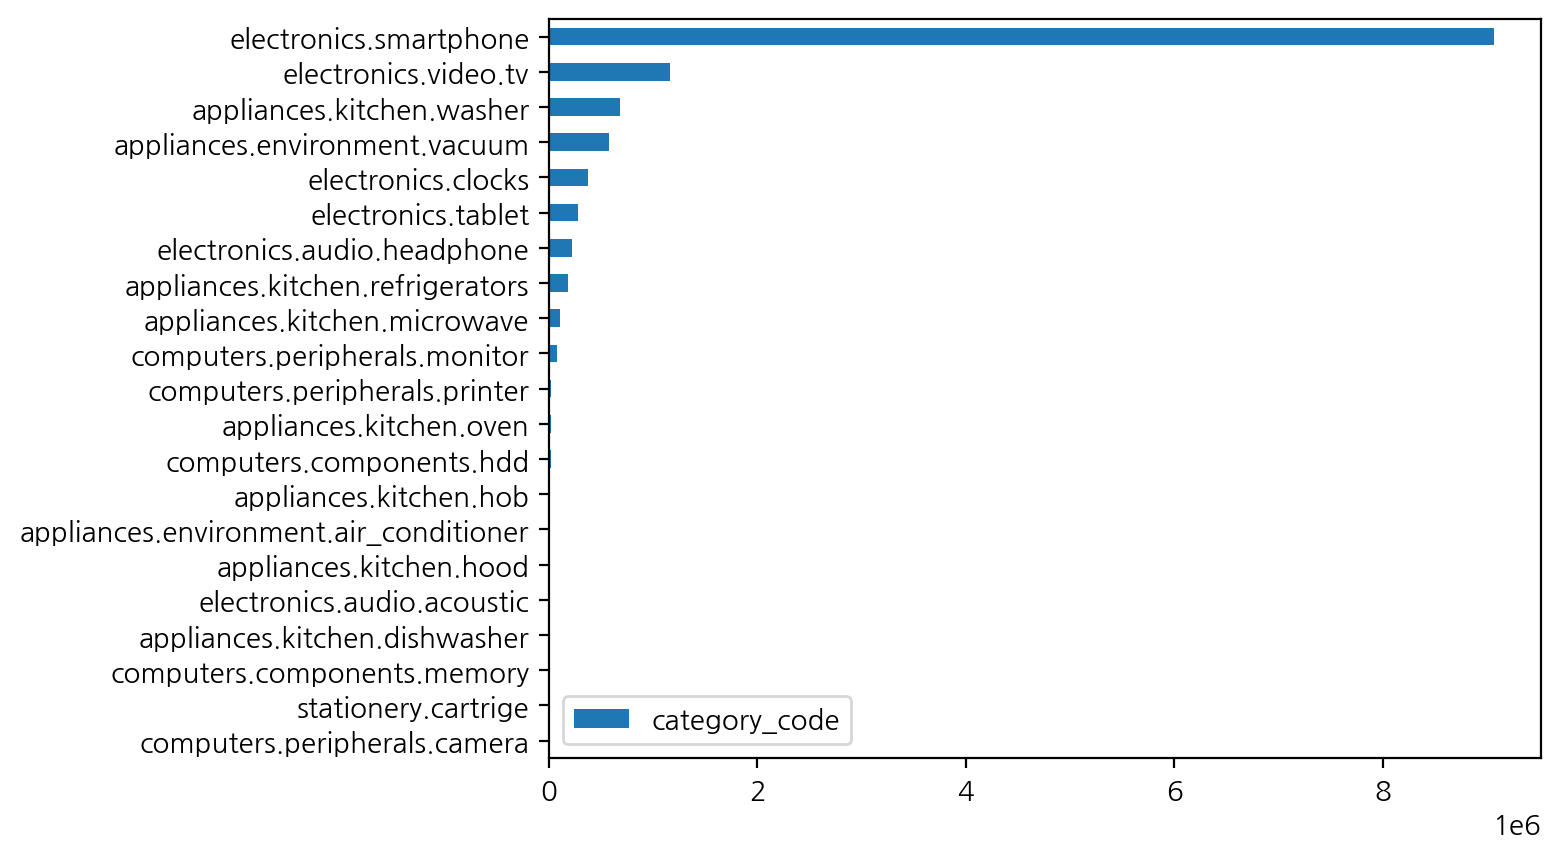

In [15]:
pd.DataFrame(categories).rename({'brand':'count'}).sort_values(by=['category_code']).plot(kind='barh');

## 삼성 카테고리 사용자들의 패턴
- 전자제품이 주력인 전자상거래의 재구매율은 보통 낮은 편
- 이런 비즈니스일수록 기존 사용자를 자주 구매하게 만드는 것보다는 신규 유입에 신경써야 함
- 검증해보자

In [16]:
# 모든 삼성 로그 중 purchase의 비율 구하기
s_per_events = samsung['event_type'].value_counts(normalize=True) * 100
s_per_events

view        90.580850
cart         6.580196
purchase     2.838954
Name: event_type, dtype: float64

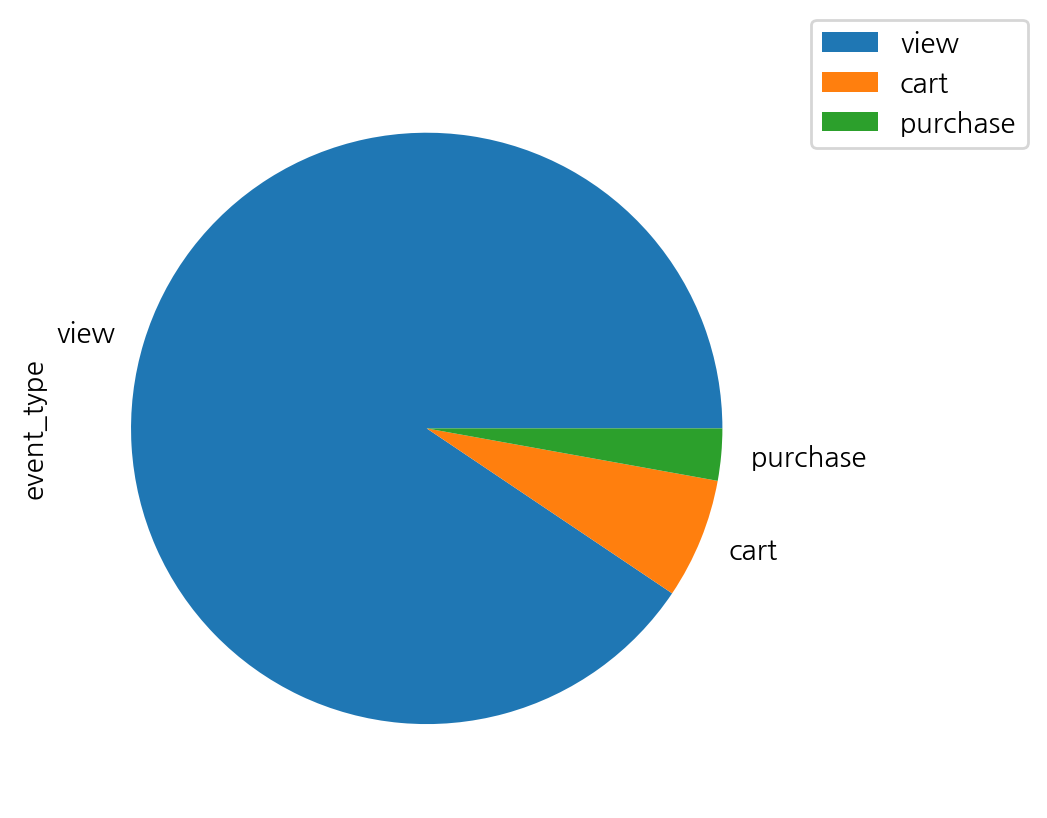

In [17]:
pd.DataFrame(s_per_events).plot.pie(y='event_type');
plt.legend(loc=(1.02, 0.88))
plt.show()

In [18]:
s_purchase = n_samsung[n_samsung['event_type'] == 'purchase']
s_purchase

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month,day,md
23,2019-10-01 00:02:14,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.759995,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,10,1,10-01
294,2019-10-01 02:21:02,purchase,1004659,2053013555631882655,electronics.smartphone,samsung,787.179993,555168263,d068d08f-aaf3-4949-b031-cdaf49a5c7cf,10,1,10-01
360,2019-10-01 02:22:11,purchase,1004750,2053013555631882655,electronics.smartphone,samsung,197.429993,555110488,ce885079-4d92-4fe6-92a3-377c5a2d8291,10,1,10-01
375,2019-10-01 02:22:31,purchase,5100719,2053013553341792533,electronics.clocks,samsung,151.610001,549614436,129d379f-0137-4bd5-bf30-90c4c7bef7c8,10,1,10-01
405,2019-10-01 02:23:10,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.759995,550146179,4078566a-62e6-4258-b623-87812d27aa62,10,1,10-01
...,...,...,...,...,...,...,...,...,...,...,...,...
13171982,2019-11-30 23:57:23,purchase,1005212,2053013555631882655,electronics.smartphone,samsung,169.089996,557794415,068b0939-1d19-4289-90d8-bb0ee2a3547a,11,30,11-30
13171983,2019-11-30 23:57:30,purchase,1004874,2053013555631882655,electronics.smartphone,samsung,346.700012,547804983,717566cf-ef93-4078-ba8f-169a3ac9f1a0,11,30,11-30
13171993,2019-11-30 23:58:08,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,235.600006,574868869,878a1538-ebe3-4d7f-b773-1b057b1971eb,11,30,11-30
13171995,2019-11-30 23:58:14,purchase,1004874,2053013555631882655,electronics.smartphone,samsung,346.700012,547804983,717566cf-ef93-4078-ba8f-169a3ac9f1a0,11,30,11-30


In [19]:
s_purchase.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372904 entries, 23 to 13172009
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event_time     372904 non-null  datetime64[ns]
 1   event_type     372904 non-null  category      
 2   product_id     372904 non-null  int64         
 3   category_id    372904 non-null  uint64        
 4   category_code  370357 non-null  object        
 5   brand          372904 non-null  object        
 6   price          372904 non-null  float32       
 7   user_id        372904 non-null  int64         
 8   user_session   372904 non-null  object        
 9   month          372904 non-null  int64         
 10  day            372904 non-null  int64         
 11  md             372904 non-null  object        
dtypes: category(1), datetime64[ns](1), float32(1), int64(4), object(4), uint64(1)
memory usage: 33.1+ MB


In [20]:
s_purchase['user_session'].isnull().sum()

0

In [21]:
purchase_count = s_purchase[["event_type","md","product_id","user_id","category_code", "price"]]
purchase_count.head()

,event_type,md,product_id,user_id,category_code,price
23,purchase,10-01,1004856,543272936,electronics.smartphone,130.759995
294,purchase,10-01,1004659,555168263,electronics.smartphone,787.179993
360,purchase,10-01,1004750,555110488,electronics.smartphone,197.429993
375,purchase,10-01,5100719,549614436,electronics.clocks,151.610001
405,purchase,10-01,1004856,550146179,electronics.smartphone,130.759995


In [22]:
purchase_count = purchase_count.dropna()
purchase_count

,event_type,md,product_id,user_id,category_code,price
23,purchase,10-01,1004856,543272936,electronics.smartphone,130.759995
294,purchase,10-01,1004659,555168263,electronics.smartphone,787.179993
360,purchase,10-01,1004750,555110488,electronics.smartphone,197.429993
375,purchase,10-01,5100719,549614436,electronics.clocks,151.610001
405,purchase,10-01,1004856,550146179,electronics.smartphone,130.759995
...,...,...,...,...,...,...
13171982,purchase,11-30,1005212,557794415,electronics.smartphone,169.089996
13171983,purchase,11-30,1004874,547804983,electronics.smartphone,346.700012
13171993,purchase,11-30,1004767,574868869,electronics.smartphone,235.600006
13171995,purchase,11-30,1004874,547804983,electronics.smartphone,346.700012


In [23]:
purchase_count_m = purchase_count.groupby('user_id').agg({'md':'nunique',
                                                          'event_type':'count',
                                                          'category_code':'unique',
                                                          'price':'sum'})
purchase_count_m

,md,event_type,category_code,price
user_id,,,,
315835876,1,1,[electronics.smartphone],169.889999
366237542,1,1,[electronics.smartphone],126.900002
389051600,1,1,[electronics.smartphone],229.910004
403013066,1,1,[electronics.smartphone],229.220001
415873351,1,2,[electronics.smartphone],263.059998
...,...,...,...,...
579953265,1,1,[electronics.smartphone],1544.160034
579953464,1,1,[electronics.smartphone],124.110001
579956024,1,1,[electronics.smartphone],282.089996


In [24]:
purchase_count_m['category_code'] = purchase_count_m['category_code'].astype('str').str[1:-1]
purchase_count_m

,md,event_type,category_code,price
user_id,,,,
315835876,1,1,'electronics.smartphone',169.889999
366237542,1,1,'electronics.smartphone',126.900002
389051600,1,1,'electronics.smartphone',229.910004
403013066,1,1,'electronics.smartphone',229.220001
415873351,1,2,'electronics.smartphone',263.059998
...,...,...,...,...
579953265,1,1,'electronics.smartphone',1544.160034
579953464,1,1,'electronics.smartphone',124.110001
579956024,1,1,'electronics.smartphone',282.089996


In [25]:
purchase_count_m = purchase_count_m.sort_values(by=['price'], ascending=False)
purchase_count_m

,md,event_type,category_code,price
user_id,,,,
530834332,24,130,'electronics.smartphone',152926.296875
564068124,30,562,'electronics.smartphone' 'electronics.tablet',122690.000000
564769842,24,138,'electronics.smartphone',101143.031250
534545940,40,106,'electronics.smartphone',93547.781250
545925192,8,75,'electronics.smartphone' 'appliances.kitchen.d...,75572.234375
...,...,...,...,...
570838653,1,1,'electronics.audio.headphone',5.610000
516769812,1,1,'electronics.audio.headphone',5.610000
546421515,1,1,'electronics.audio.headphone',5.610000


In [26]:
event_type_count = n_samsung[['event_type','md','product_id','user_id']]
event_type_count.head()

,event_type,md,product_id,user_id
0,view,10-01,1005011,530282093
1,view,10-01,3601505,526631741
2,view,10-01,1004767,512558158
3,view,10-01,1004659,512558158
4,view,10-01,1004873,555447651


In [27]:
item = event_type_count.groupby(['md','event_type']).agg({'product_id':'count'})
item = item.reset_index()
item

,md,event_type,product_id
0,10-01,cart,5720
1,10-01,purchase,4425
2,10-01,view,135417
3,10-02,cart,5925
4,10-02,purchase,4618
...,...,...,...
178,11-29,purchase,7491
179,11-29,view,206614
180,11-30,cart,15847
181,11-30,purchase,6769


In [28]:
# 11월 시작 행 찾기
item[item['md'] == '11-01']

,md,event_type,product_id
93,11-01,cart,6210
94,11-01,purchase,5291
95,11-01,view,163410


In [29]:
# 데이터  자르기
Oct_item = item.loc[:92]
Nov_item = item.loc[93:]

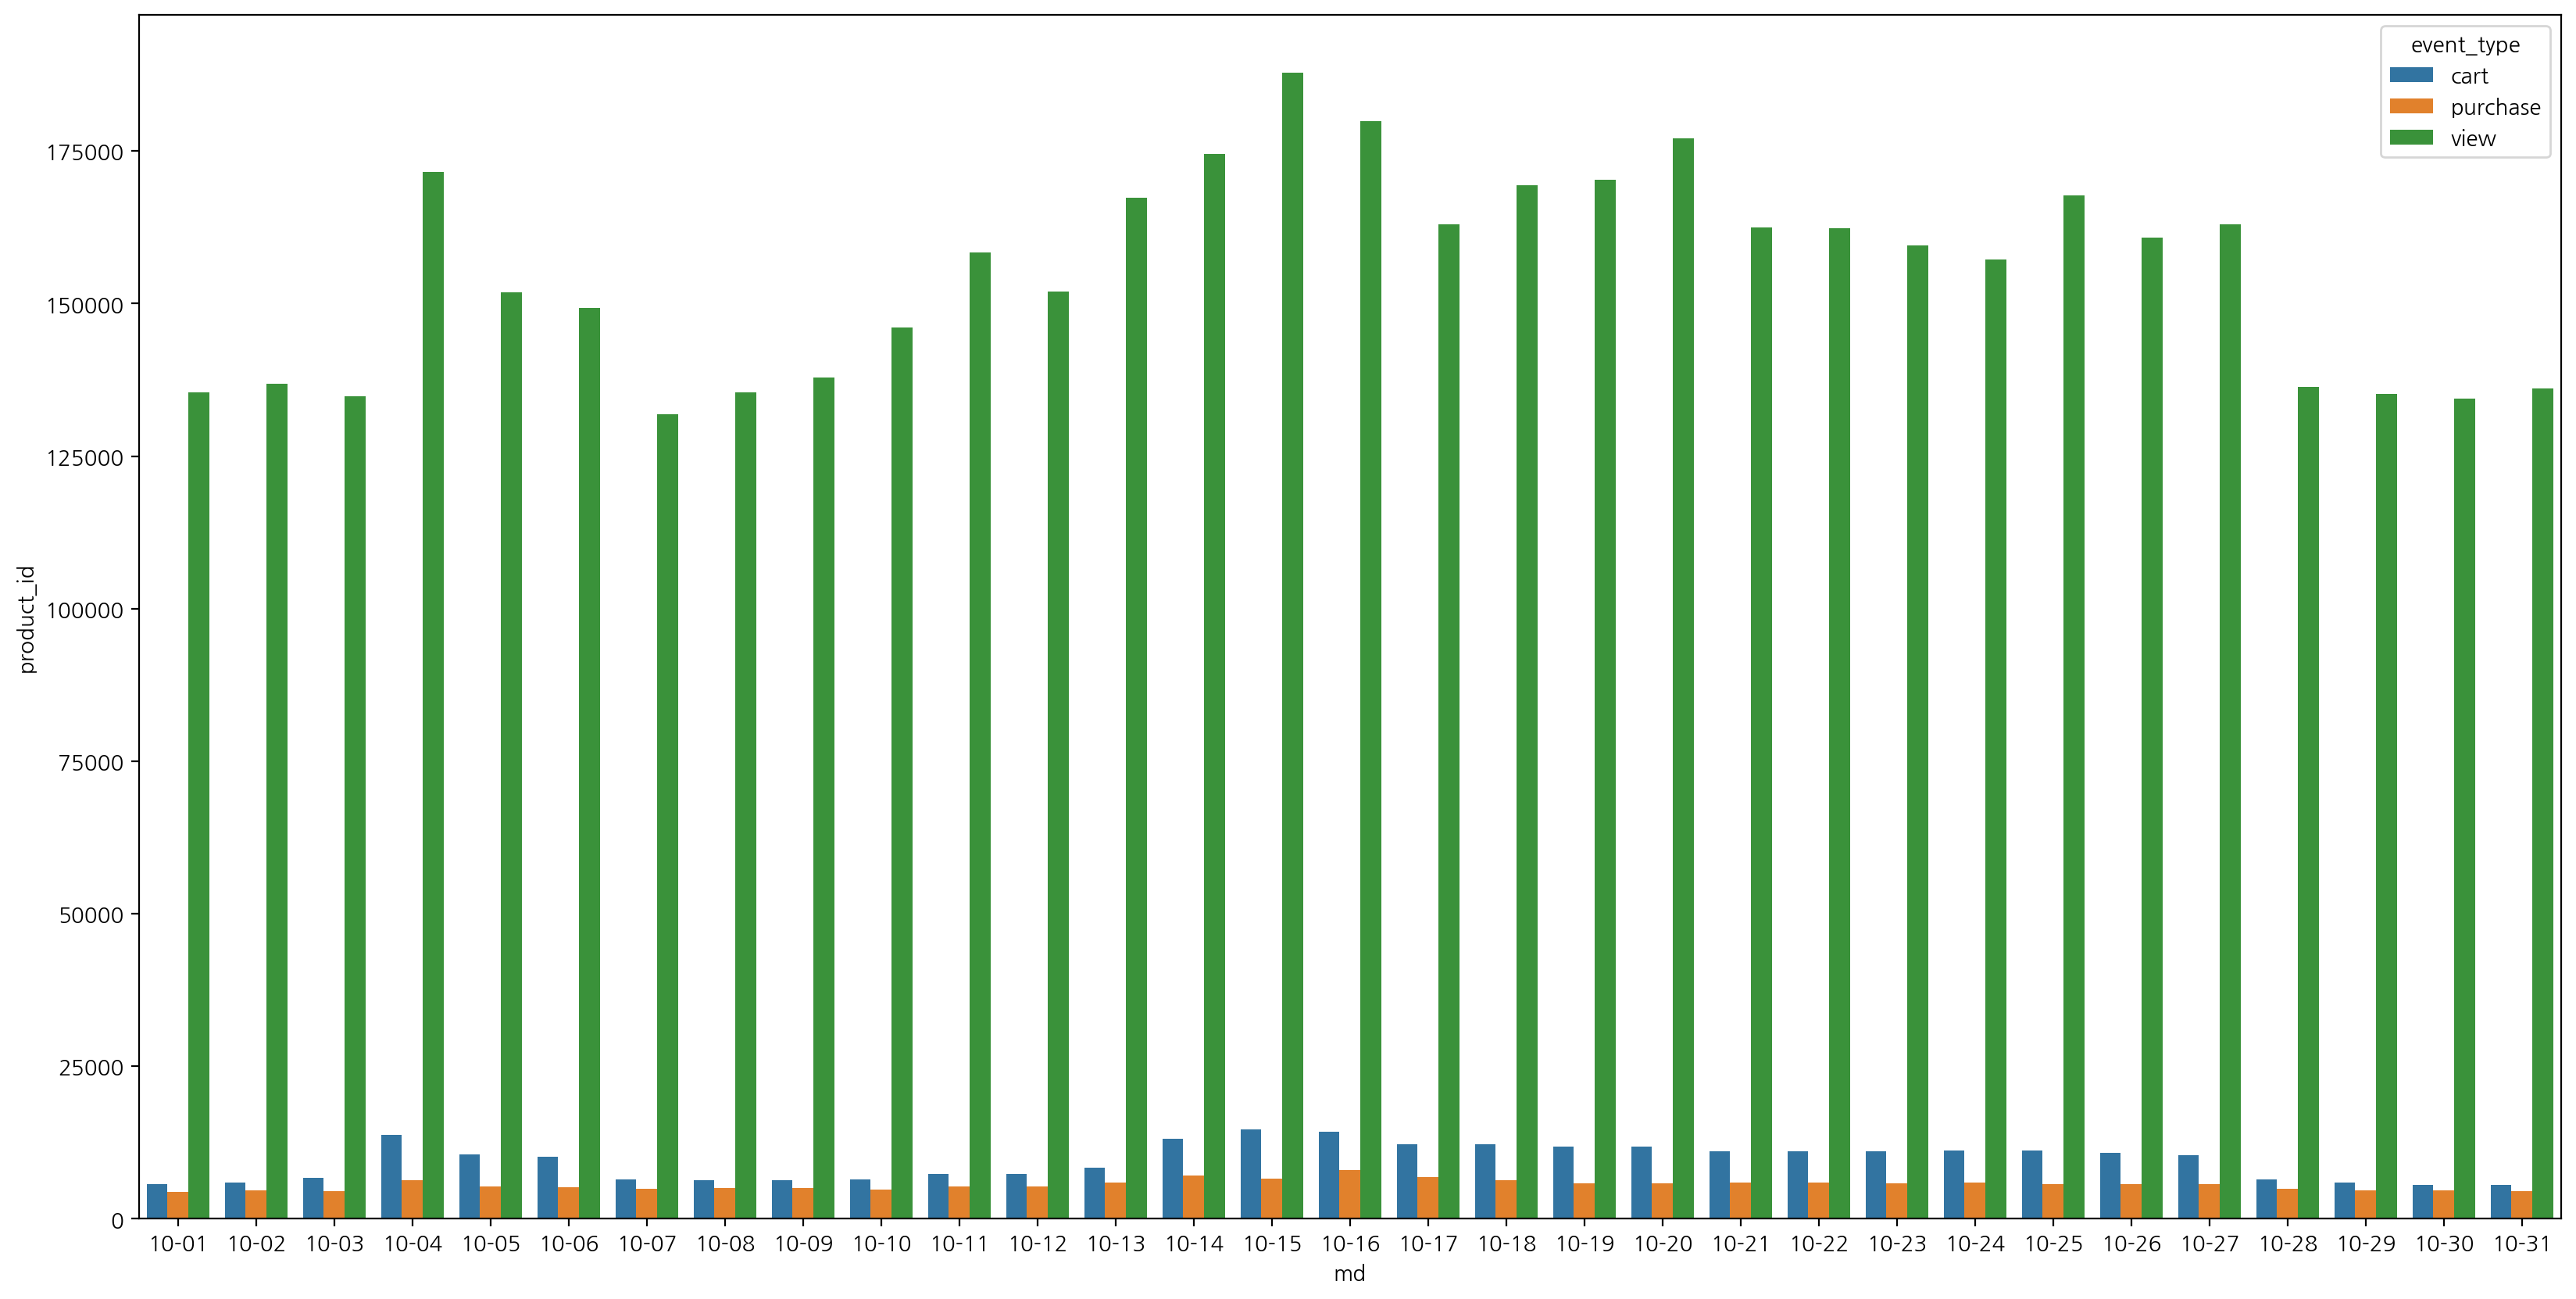

In [30]:
plt.figure(figsize=(20,10))
sns.barplot(data = Oct_item, x='md', y='product_id', hue='event_type');

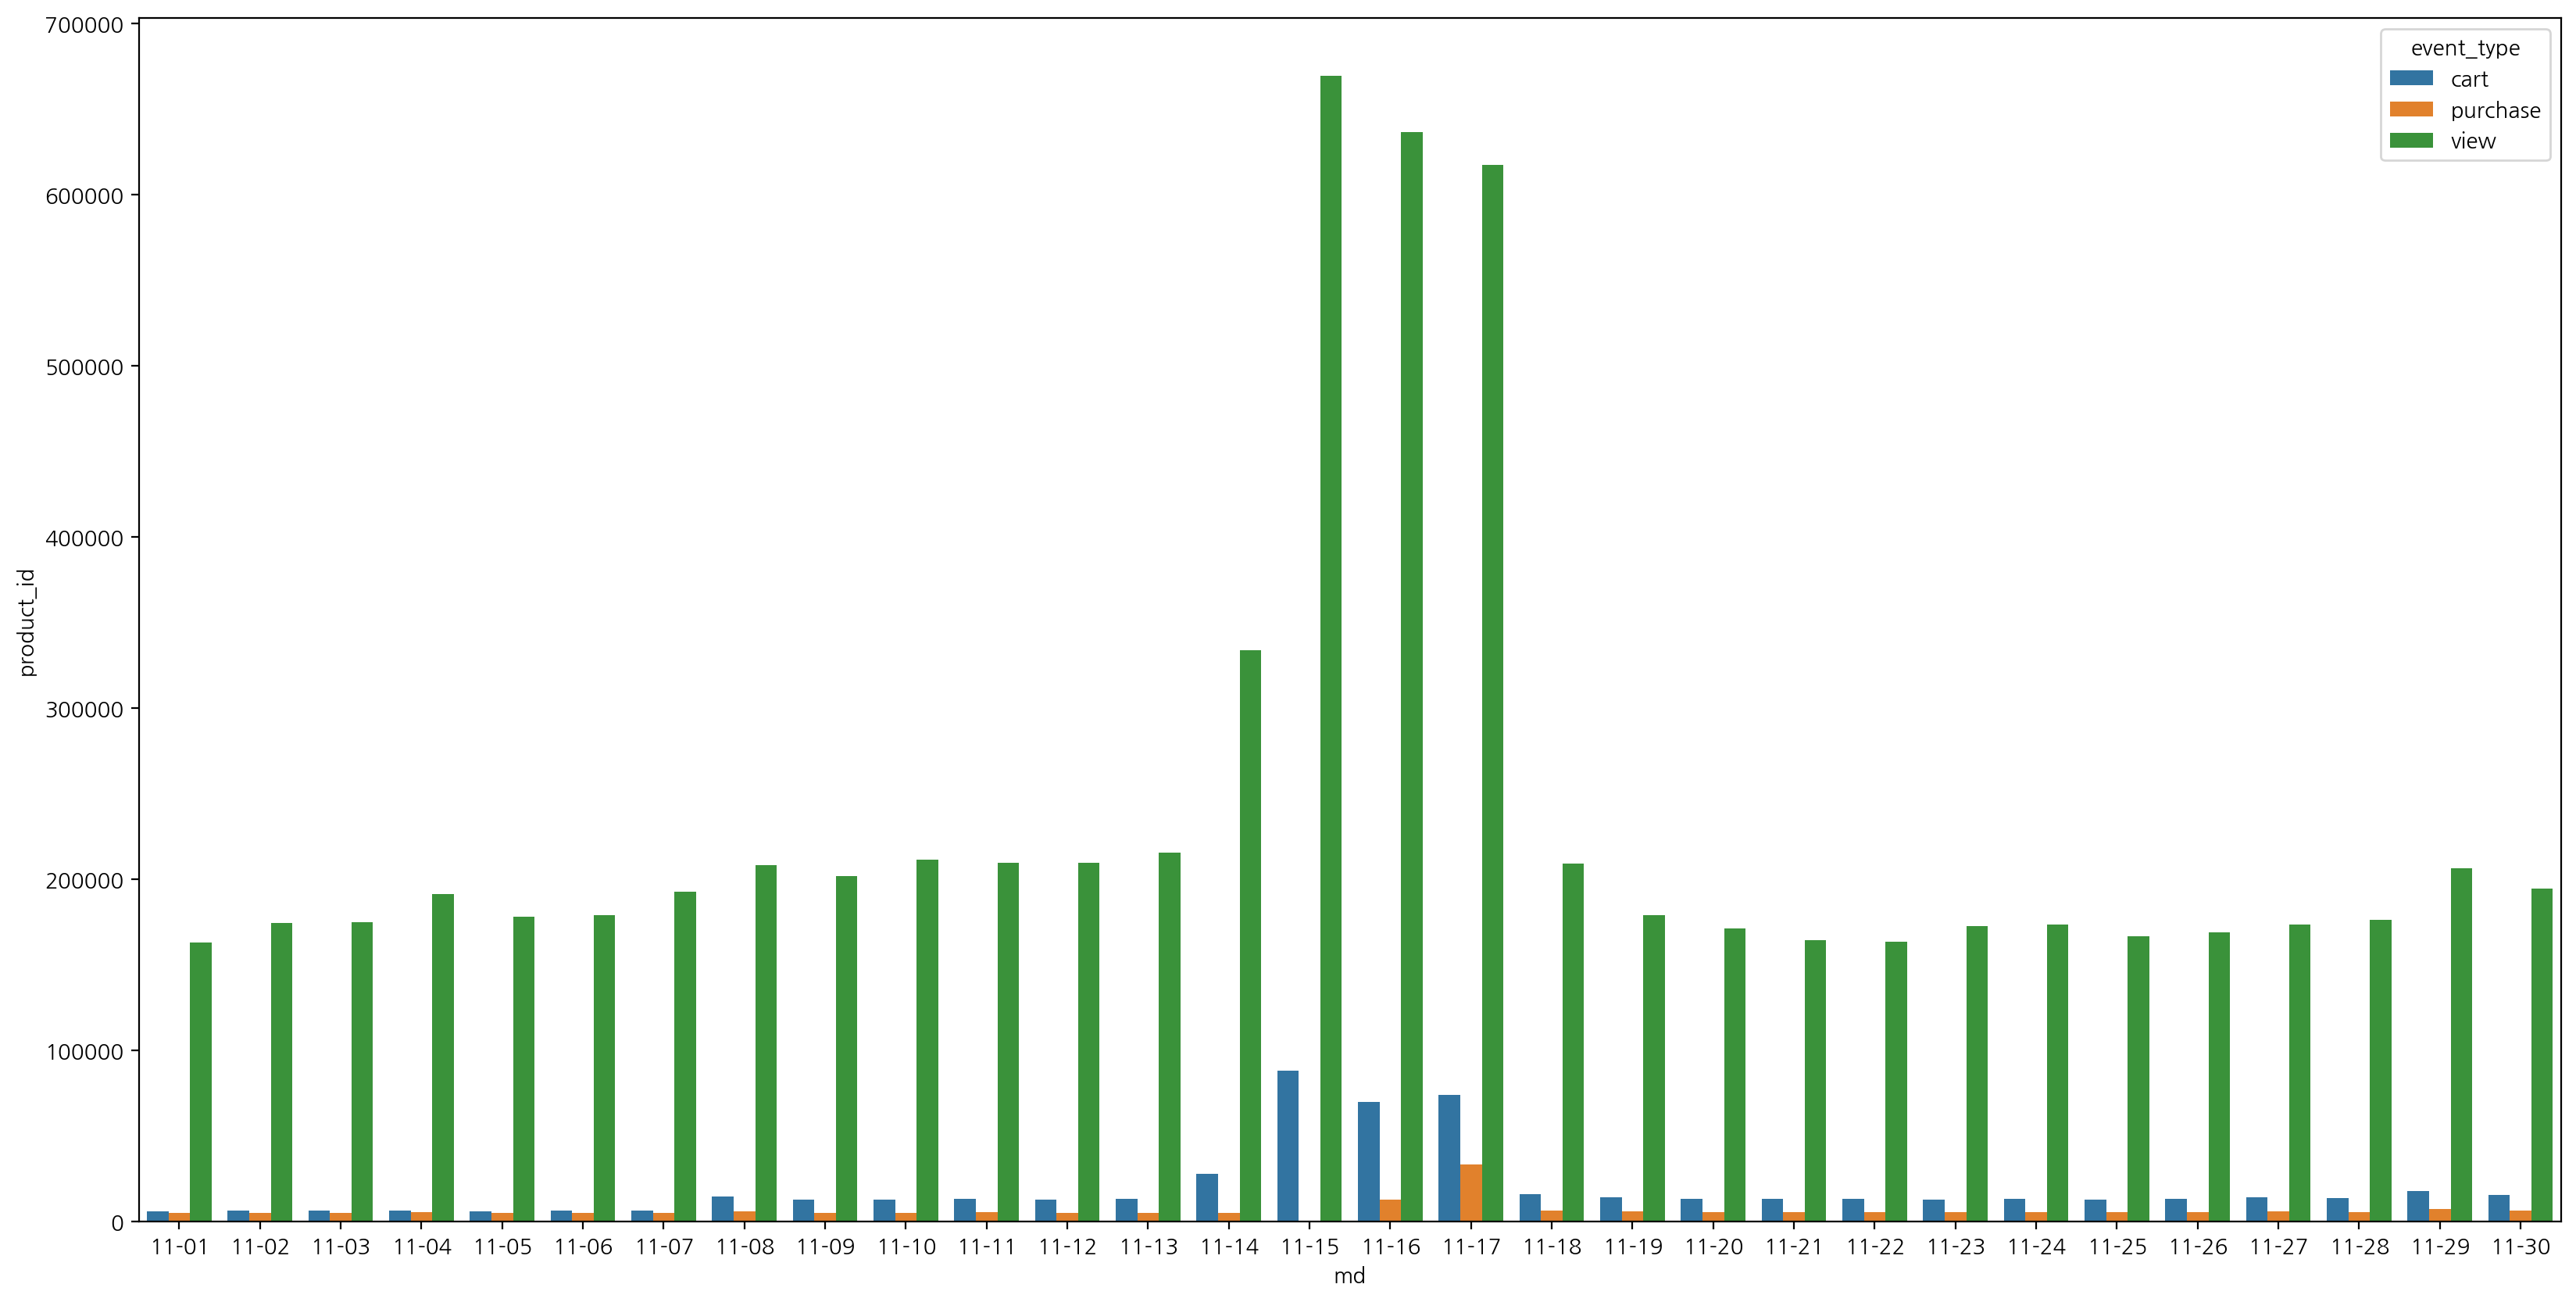

In [31]:
plt.figure(figsize=(20,10))
sns.barplot(data = Nov_item, x='md', y='product_id', hue='event_type');

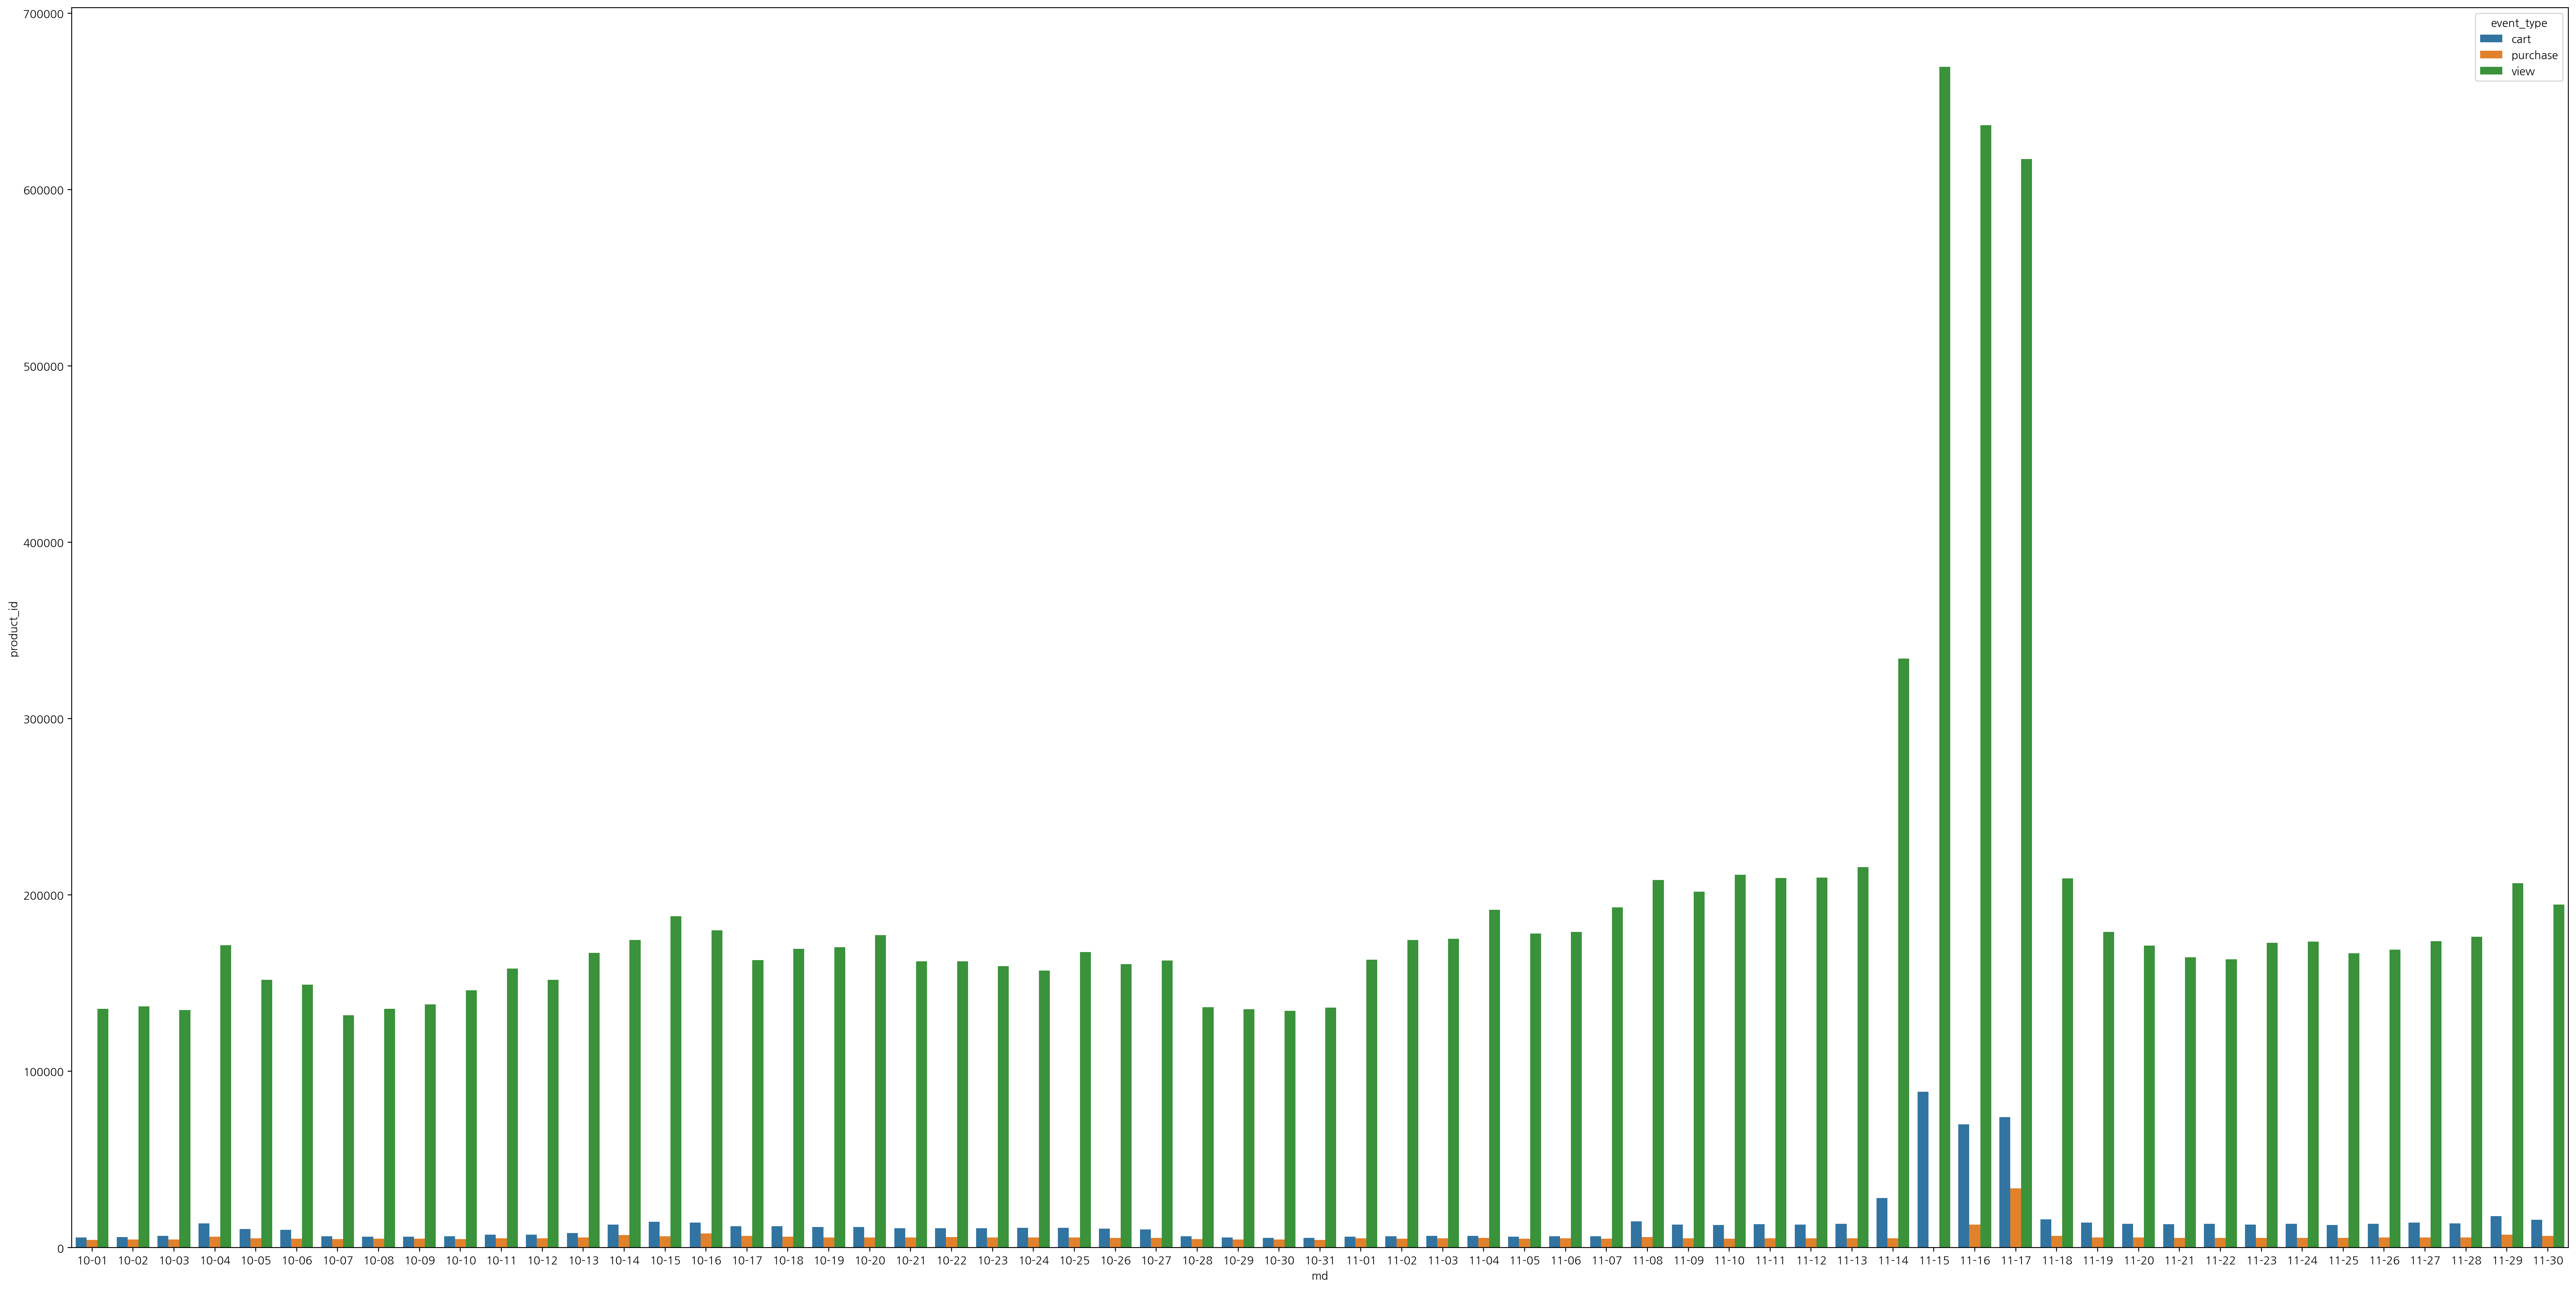

In [32]:
plt.figure(figsize=(40,20))
sns.barplot(data = item, x='md', y='product_id', hue='event_type');

## 일별 활성 사용자 수

In [33]:
day_samsung = n_samsung[['md', 'user_id']]
day_samsung.head()

,md,user_id
0,10-01,530282093
1,10-01,526631741
2,10-01,512558158
3,10-01,512558158
4,10-01,555447651


In [34]:
result = day_samsung.drop_duplicates()
g = result.groupby(['md']).agg({'user_id':'count'})
g = g.reset_index()
g.dtypes

md         object
user_id     int64
dtype: object

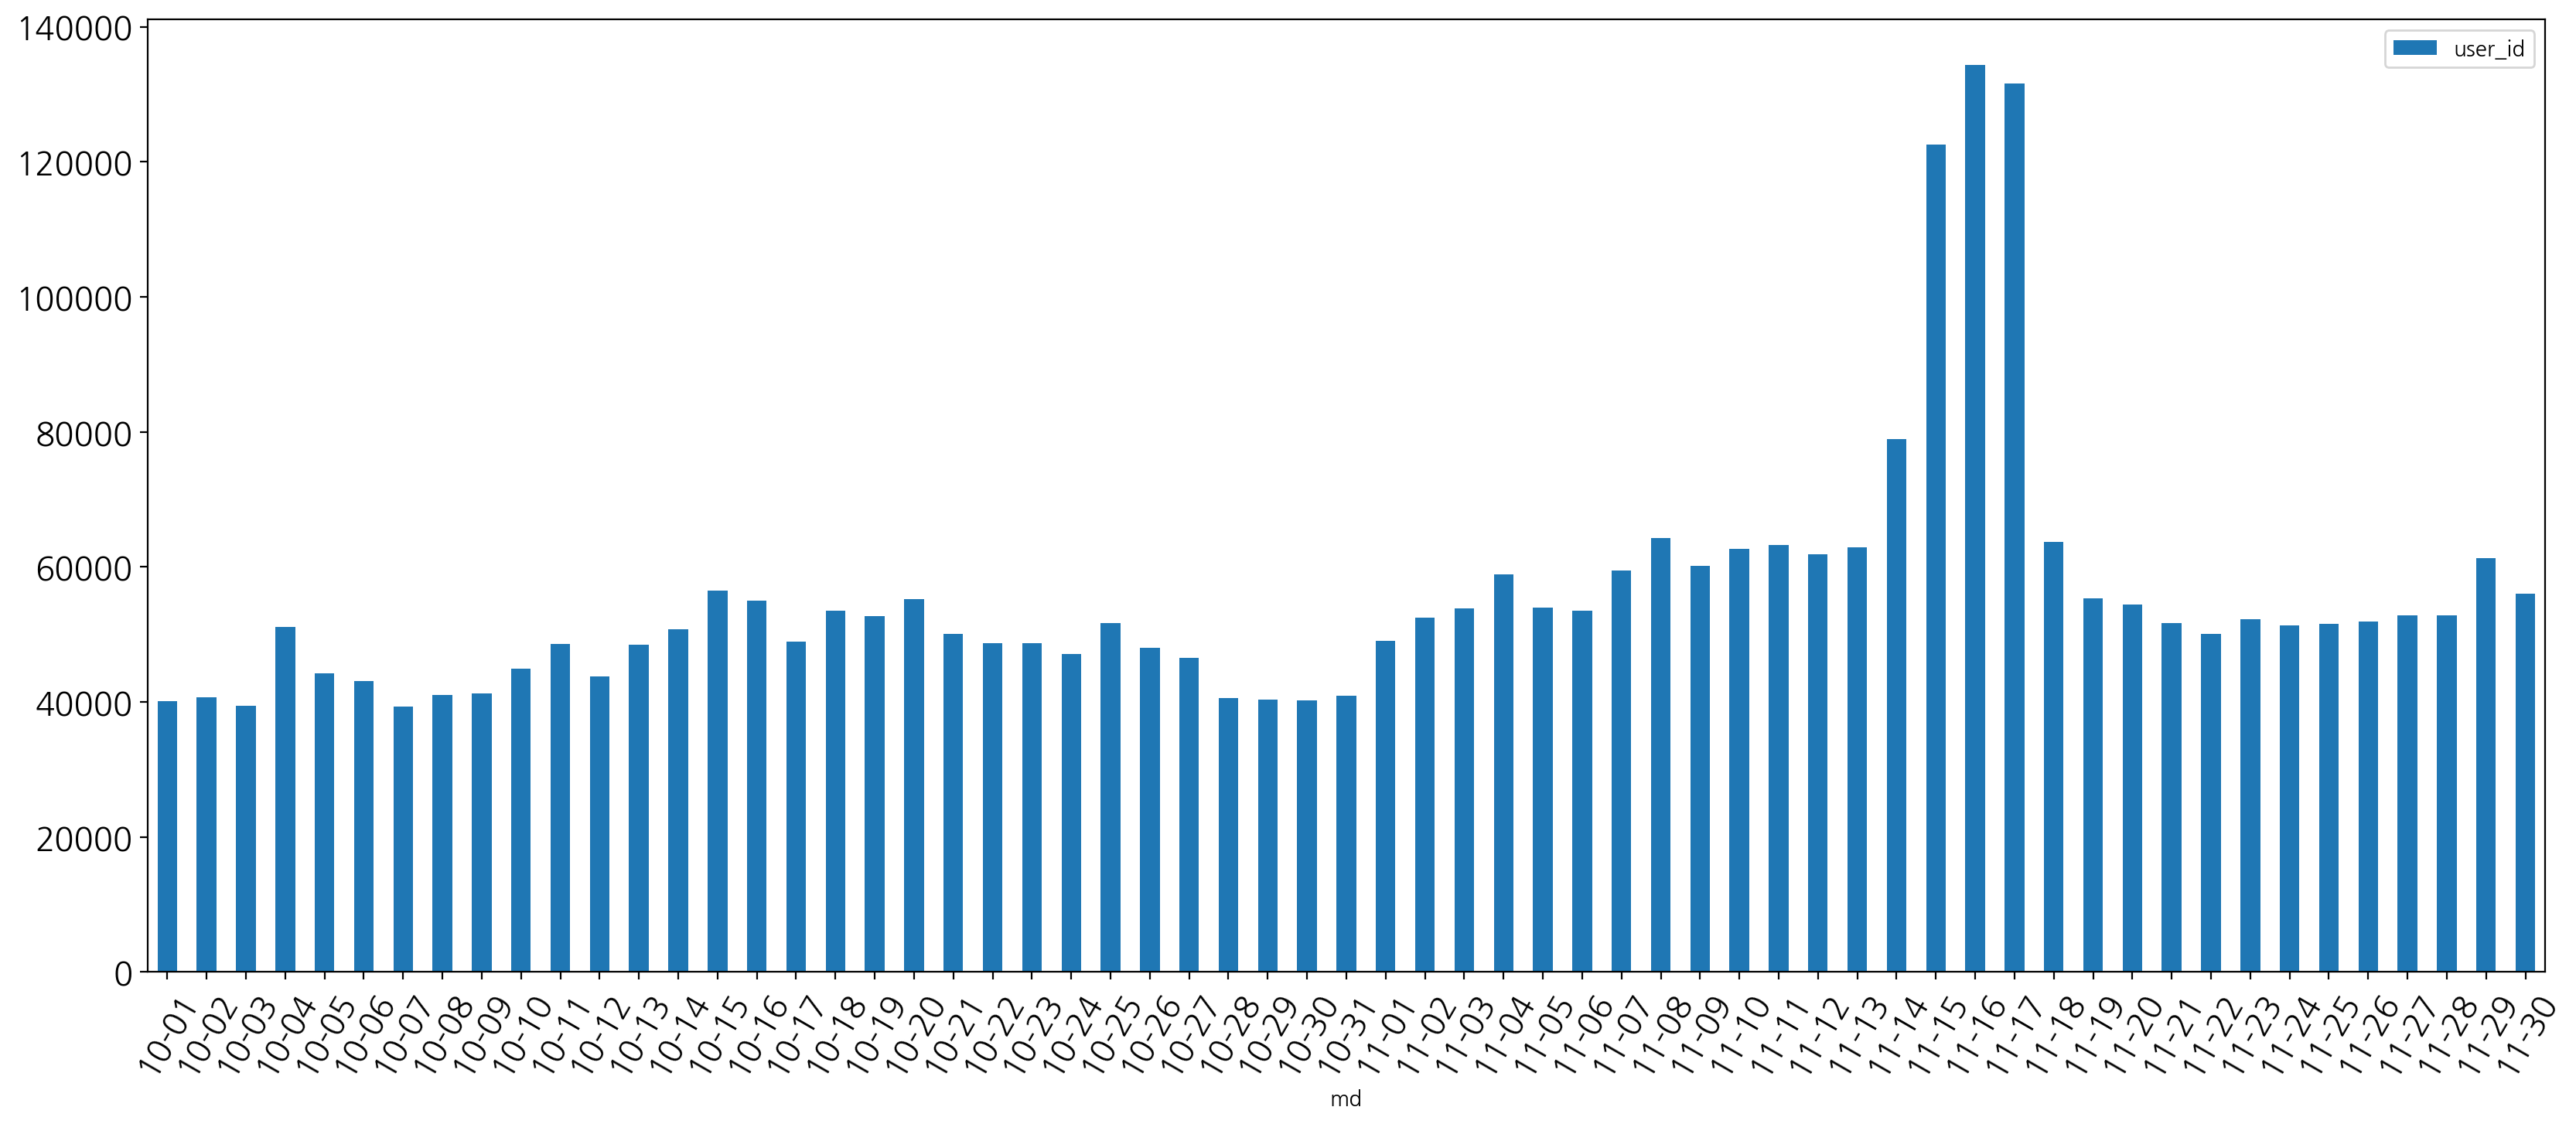

In [35]:
g.plot.bar(figsize=(20,8), x='md', y='user_id', rot=60, fontsize=15);

## 요일별 추이

In [36]:
samsung['days'] = samsung['event_time'].dt.strftime('%w')
days = samsung.groupby(['days','event_type']).size().reset_index(name='total')
days.head(10)

,days,event_type,total
0,0,cart,147826
1,0,purchase,72352
2,0,view,1834280
3,1,cart,86275
4,1,purchase,46036
5,1,view,1383054
6,2,cart,90803
7,2,purchase,48775
8,2,view,1492366
9,3,cart,90866


In [37]:
# 이벤트별로 묶어주기
event_view = days[days['event_type']=='view'].copy()
event_cart = days[days['event_type']=='cart'].copy()
event_purchase = days[days['event_type']=='purchase'].copy()

# index reset
event_view.reset_index(drop=True)
event_cart.reset_index(drop=True)
event_purchase.reset_index(drop=True)

# 요일명으로 변경
day =['일','월','화', '수', '목', '금','토']
event_view['days'] = day
event_cart['days'] = day
event_purchase['days'] = day

event_view

,days,event_type,total
2,일,view,1834280
5,월,view,1383054
8,화,view,1492366
11,수,view,1488554
14,목,view,1605335
17,금,view,2078836
20,토,view,2015607


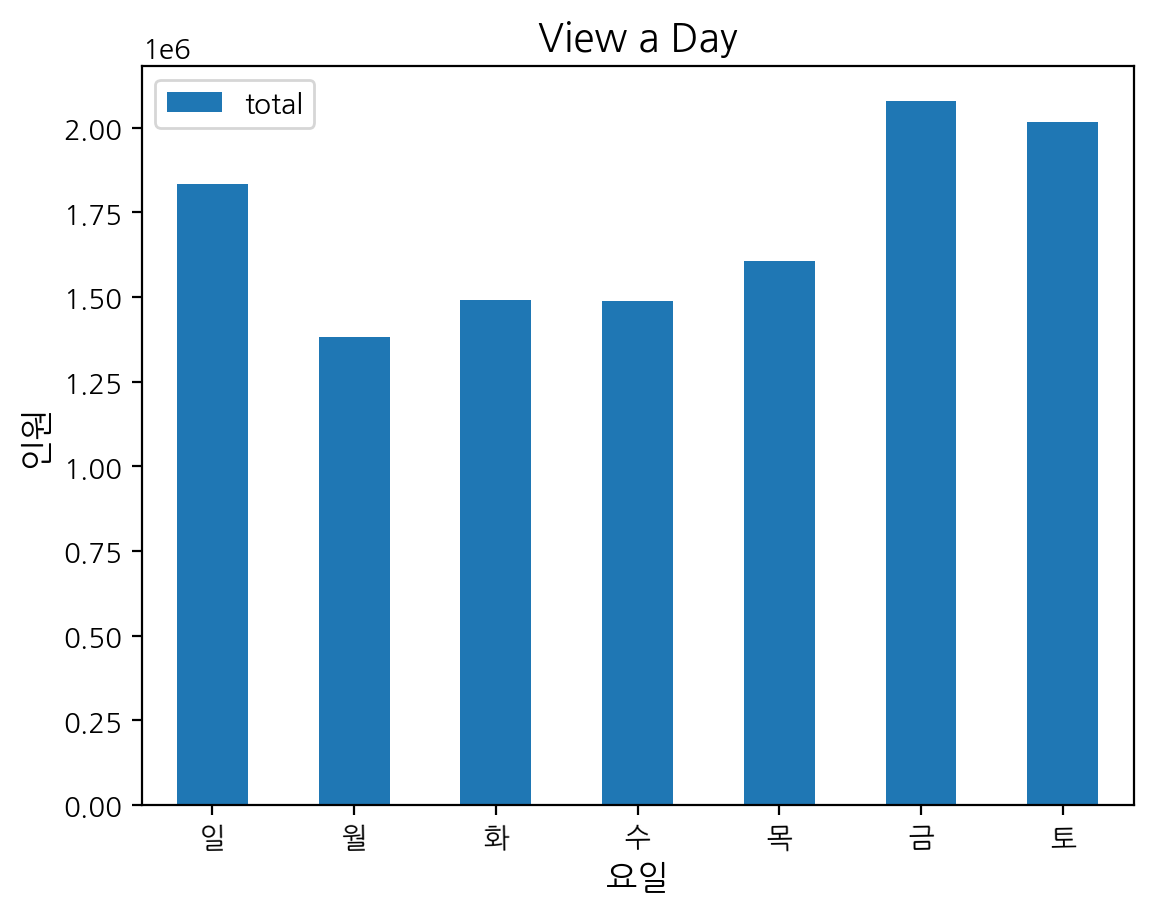

In [38]:
# view 추이
event_view.plot(kind='bar', x='days', y='total', rot=1)
plt.title('View a Day', fontsize=14)
plt.xlabel('요일', fontsize=12)
plt.ylabel('인원', fontsize=12)
plt.show()

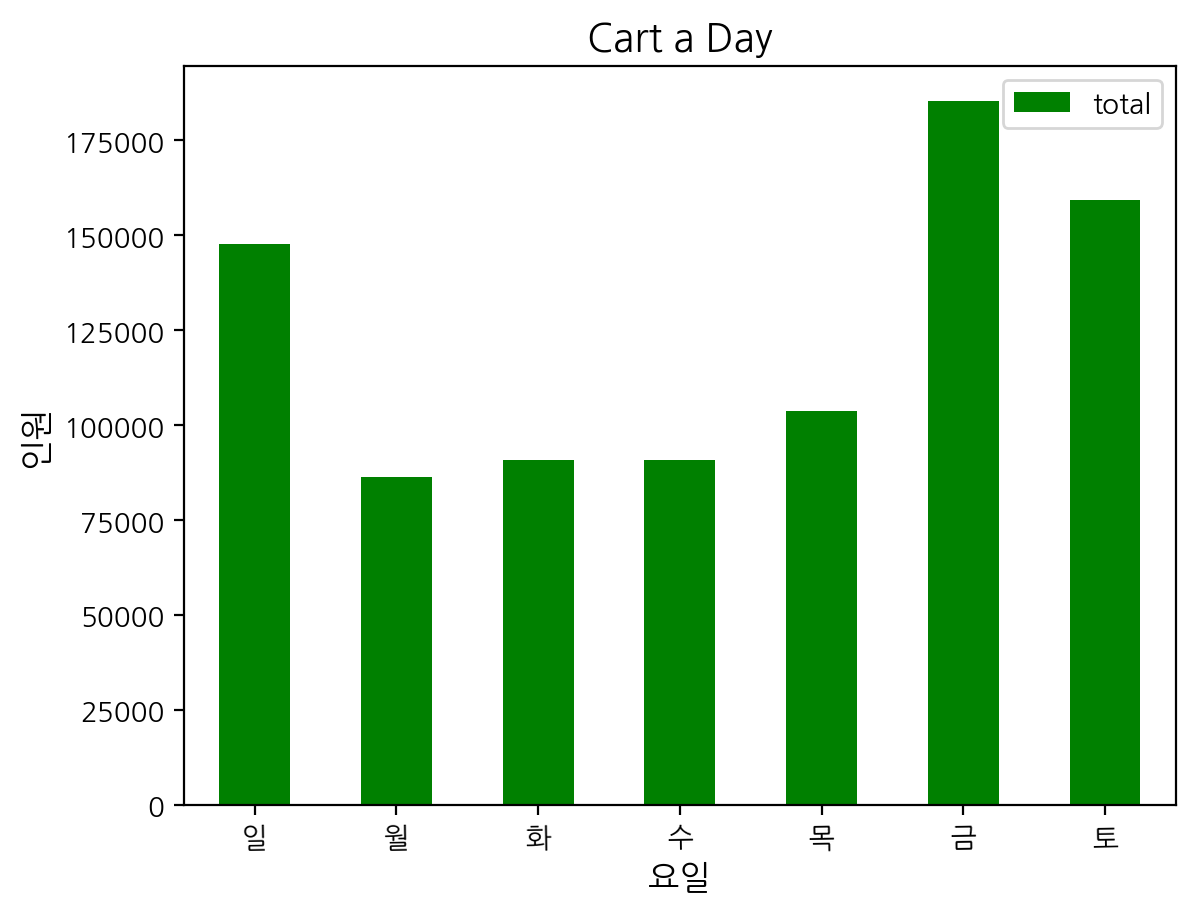

In [39]:
# cart 추이
event_cart.plot(kind='bar', x='days', y='total', rot=1, color='g')
plt.title('Cart a Day', fontsize=14)
plt.xlabel('요일', fontsize=12)
plt.ylabel('인원', fontsize=12)
plt.show()

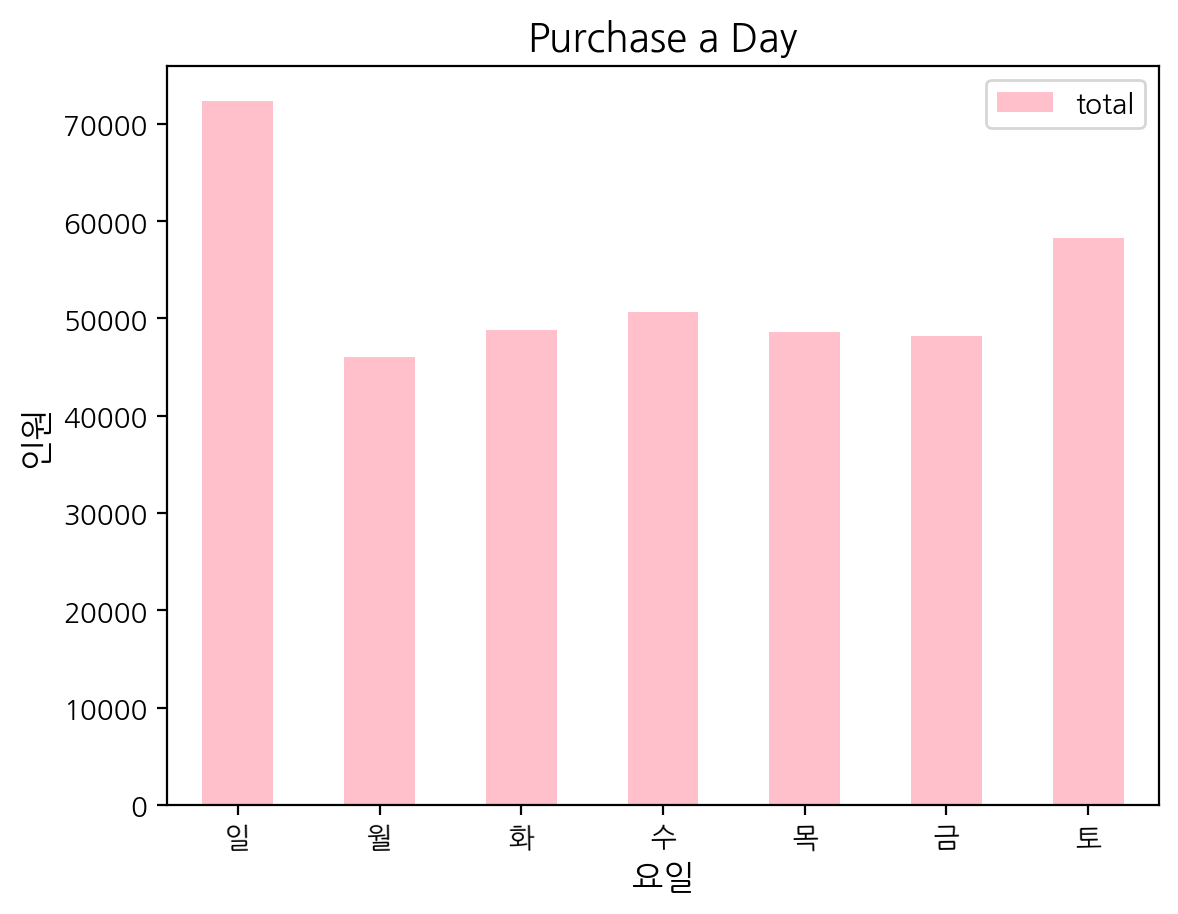

In [40]:
# purchase 추이
event_purchase.plot(kind='bar', x='days', y='total', rot=1, color='pink')
plt.title('Purchase a Day', fontsize=14)
plt.xlabel('요일', fontsize=12)
plt.ylabel('인원', fontsize=12)
plt.show()

In [41]:
pv_days = pd.pivot_table(days,
                        index='days',
                        columns='event_type',
                        values='total',
                        aggfunc='sum')
pv_days.index = day
pv_days = pv_days[['view', 'cart', 'purchase']]
pv_days

event_type,view,cart,purchase
일,1834280,147826,72352
월,1383054,86275,46036
화,1492366,90803,48775
수,1488554,90866,50661
목,1605335,103855,48581
금,2078836,185385,48231
토,2015607,159316,58268


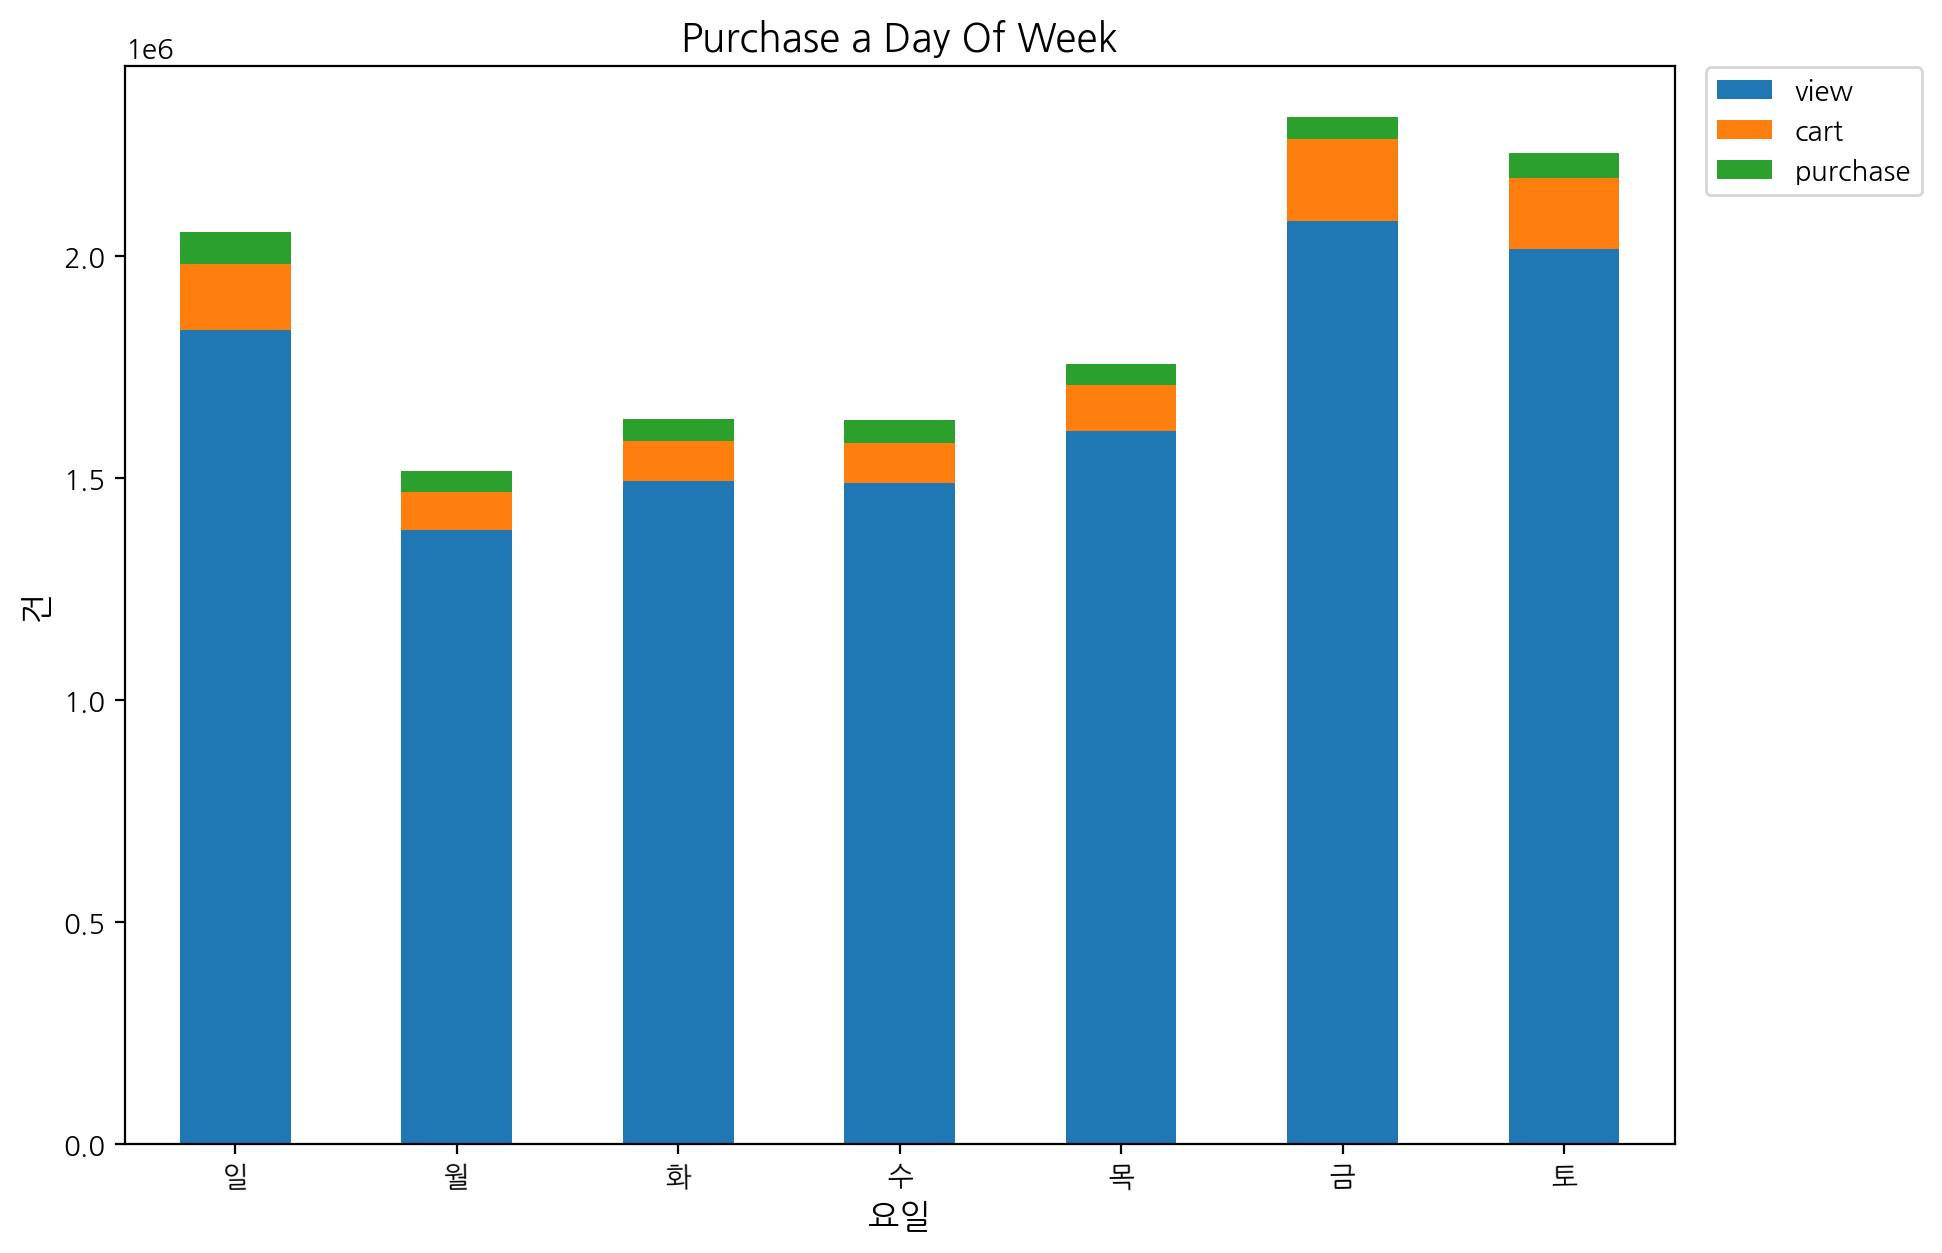

In [42]:
# purchase 추이
pv_days.plot.bar(stacked=True, figsize=(10, 7), rot=1);
plt.title('Purchase a Day Of Week', fontsize=14)
plt.xlabel('요일', fontsize=12)
plt.ylabel('건', fontsize=12)
plt.legend(loc=(1.02, 0.88))
plt.show()

## RFM 분석
- RFM 점수 = a * Recency 점수 + b * Frequency 점수 + c * Monetary 점수
- R, M에 더 큰 상수를 부여 (상대적 분석)

### 유효데이터 만들기

In [43]:
raw = samsung[['user_id','event_type','event_time','price','user_session']]
raw.shape

(13135262, 5)

In [44]:
# 구매 데이터만 가져오기
raw = raw[raw['event_type'] == 'purchase'].reset_index(drop=True)
raw.shape

(372904, 5)

In [45]:
raw.head(2)

,user_id,event_type,event_time,price,user_session
0,543272936,purchase,2019-10-01 00:02:14,130.759995,8187d148-3c41-46d4-b0c0-9c08cd9dc564
1,555168263,purchase,2019-10-01 02:21:02,787.179993,d068d08f-aaf3-4949-b031-cdaf49a5c7cf


### user_session으로 만들기
- 판매 수는 user_id가 아닌, user_session과 비례 관계
- Date_order : 가장 최근 거래 시간
- user_id : 유저 id
- Quantity : user_session count (건당 구매 수량)
- spent : 건당 지출 금액

In [46]:
raw = raw.groupby(by='user_session').agg(Date_order=('event_time',lambda x: x.max()),
                                         user_id=('user_id','unique'),
                                         Quantity=('user_session','count'),
                                         spent=('price','sum')).reset_index(drop=True)
raw

,Date_order,user_id,Quantity,spent
0,2019-10-06 11:34:30,[546521725],1,289.519989
1,2019-10-25 08:39:11,[560486342],1,171.899994
2,2019-11-11 03:35:34,[566954797],1,151.610001
3,2019-10-24 09:08:58,[513622224],1,131.509995
4,2019-10-19 11:15:20,[561610048],2,422.000000
...,...,...,...,...
323046,2019-11-11 11:02:45,[530408758],1,243.509995
323047,2019-11-05 04:54:08,[516516131],1,170.070007
323048,2019-11-17 14:47:28,[521378371],1,269.970001
323049,2019-11-24 08:34:23,[513821974],1,977.859985


In [47]:
raw['user_id'] = raw['user_id'].astype('str').str[1:10]

In [48]:
raw['user_id']

0         546521725
1         560486342
2         566954797
3         513622224
4         561610048
            ...    
323046    530408758
323047    516516131
323048    521378371
323049    513821974
323050    519073108
Name: user_id, Length: 323051, dtype: object

### 결측치 확인

In [49]:
# 결측치 확인
raw.isnull().sum()

Date_order    0
user_id       0
Quantity      0
spent         0
dtype: int64

### 데이터 타입 확인

In [50]:
raw.dtypes

Date_order    datetime64[ns]
user_id               object
Quantity               int64
spent                float32
dtype: object

### 이상치 확인 및 제거
https://gannigoing.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%9D%B4%EC%83%81%EC%B9%98-outlier-%EC%9D%98-%EA%B8%B0%EC%A4%80%EC%9D%80-%EB%AC%B4%EC%97%87%EC%9D%BC%EA%B9%8C-f11f60bf901a

In [51]:
raw['spent'].describe()

count    323051.000000
mean        313.407135
std         311.967682
min           1.260000
25%         132.869995
50%         241.940002
75%         360.109985
max       37635.550781
Name: spent, dtype: float64

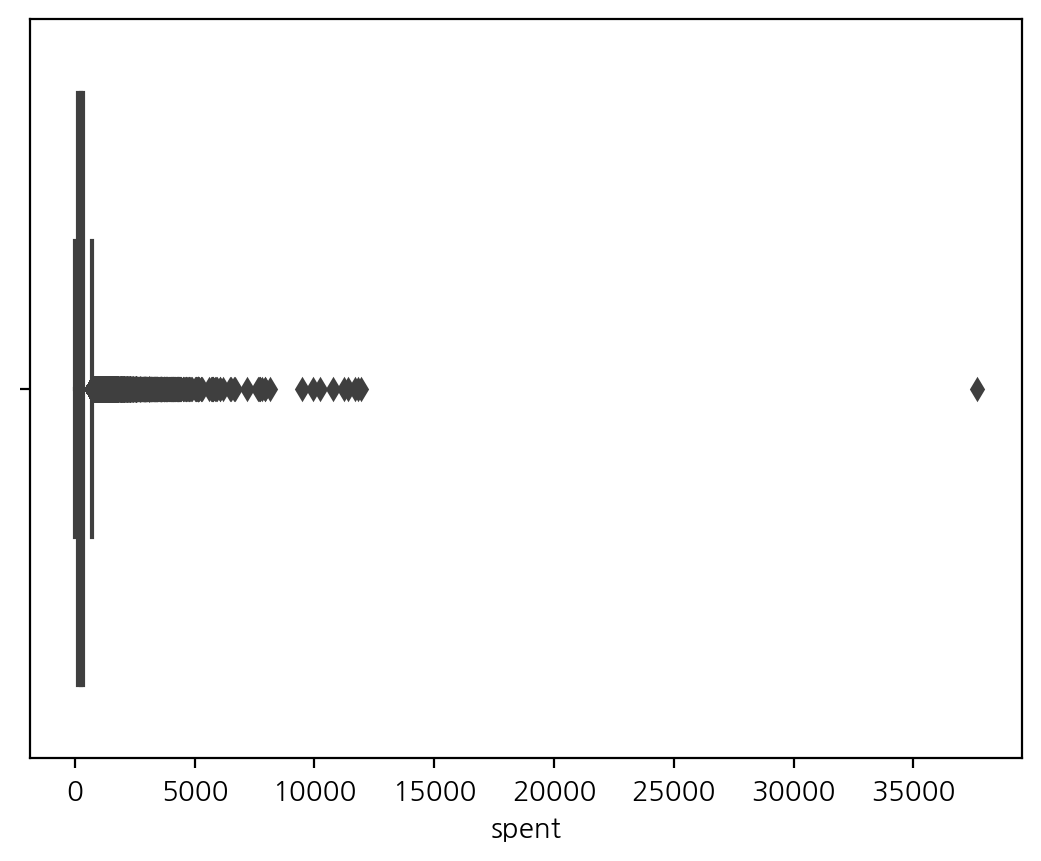

In [52]:
sns.boxplot(x=raw['spent']);

In [53]:
q1 = raw['spent'].quantile(0.25)
q2 = raw['spent'].quantile(0.5)
q3 = raw['spent'].quantile(0.75)
iqr = q3 - q1
iqr

227.239990234375

In [54]:
outliers = raw[['spent']][(raw['spent'] < (q1 - 1.5 * iqr)) | (raw['spent'] > (q3 + 1.5 * iqr))]
outliers

,spent
44,849.159973
52,1399.360107
64,771.940002
80,1217.869995
85,1271.760010
...,...
322981,776.719971
323024,1134.479980
323034,727.349976
323036,5147.580078


In [55]:
raw_valid = raw[~raw.index.isin(outliers.index)].reset_index(drop=True)
raw_valid 

,Date_order,user_id,Quantity,spent
0,2019-10-06 11:34:30,546521725,1,289.519989
1,2019-10-25 08:39:11,560486342,1,171.899994
2,2019-11-11 03:35:34,566954797,1,151.610001
3,2019-10-24 09:08:58,513622224,1,131.509995
4,2019-10-19 11:15:20,561610048,2,422.000000
...,...,...,...,...
294560,2019-10-10 12:34:49,517051774,1,130.119995
294561,2019-11-11 11:02:45,530408758,1,243.509995
294562,2019-11-05 04:54:08,516516131,1,170.070007
294563,2019-11-17 14:47:28,521378371,1,269.970001


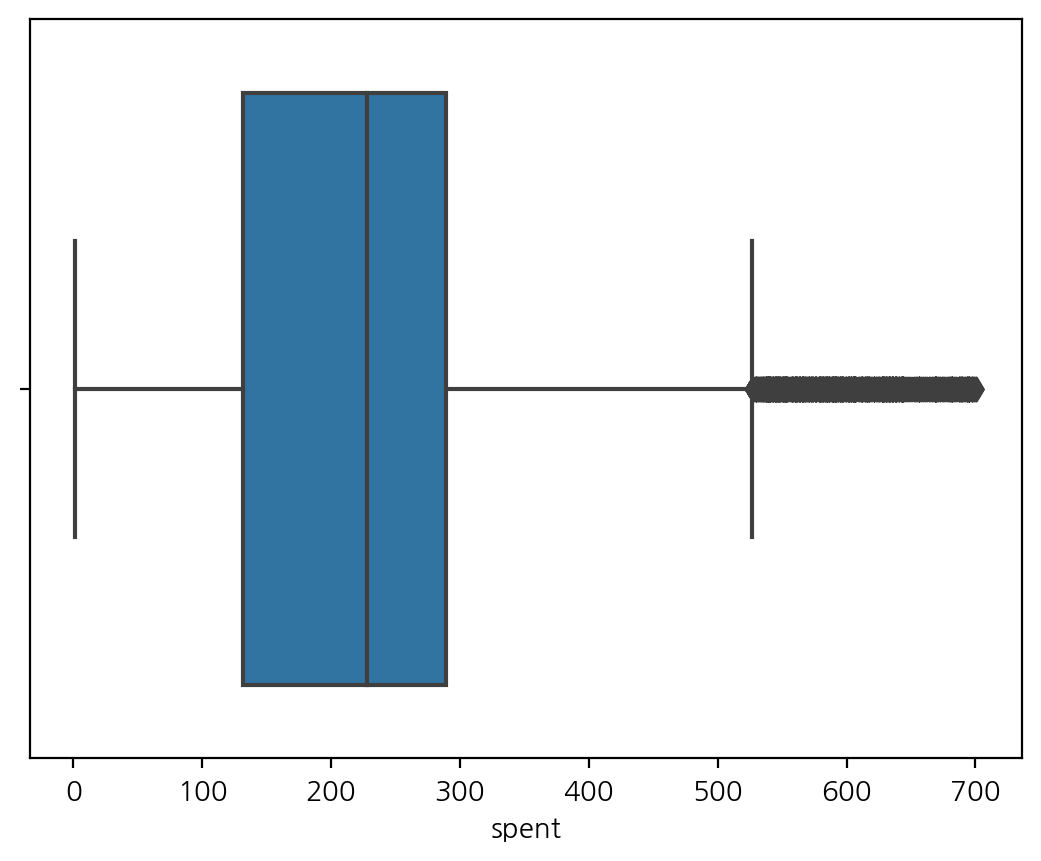

In [56]:
sns.boxplot(x=raw_valid['spent']);

https://oak.jejunu.ac.kr/bitstream/2020.oak/23663/2/RFM%20%EB%AA%A8%ED%98%95%EC%9D%98%20%EA%B0%80%EC%A4%91%EC%B9%98%20%EC%84%A0%ED%83%9D%EC%97%90%20%EA%B4%80%ED%95%9C%20%EC%97%B0%EA%B5%AC.pdf
에 근거하여 이상치 제거 안하기로 결정

In [57]:
raw

,Date_order,user_id,Quantity,spent
0,2019-10-06 11:34:30,546521725,1,289.519989
1,2019-10-25 08:39:11,560486342,1,171.899994
2,2019-11-11 03:35:34,566954797,1,151.610001
3,2019-10-24 09:08:58,513622224,1,131.509995
4,2019-10-19 11:15:20,561610048,2,422.000000
...,...,...,...,...
323046,2019-11-11 11:02:45,530408758,1,243.509995
323047,2019-11-05 04:54:08,516516131,1,170.070007
323048,2019-11-17 14:47:28,521378371,1,269.970001
323049,2019-11-24 08:34:23,513821974,1,977.859985


In [58]:
raw.iloc[raw['spent'].nlargest(1).index]

,Date_order,user_id,Quantity,spent
298579,2019-10-13 03:29:41,530834332,31,37635.550781


### 구매 건당 지출 금액

In [59]:
raw['spent'].describe()

count    323051.000000
mean        313.407135
std         311.967682
min           1.260000
25%         132.869995
50%         241.940002
75%         360.109985
max       37635.550781
Name: spent, dtype: float64

## R, F, M 계산하기
- Recency는 가장 최근 구매일로부터 경과한 일수
- Frequency는 고객의 총 구매 횟수
- Monetary는 총 구매

### 전체 주문에서 최근 구매일 구하기

In [60]:
# 최근 구매일 계산
last_timestamp = samsung['event_time'].max() + dt.timedelta(days=1)
last_timestamp

Timestamp('2019-12-01 23:59:59')

### 고객별 Recency, Frequency, Monetary 값 구하기

In [61]:
rfm = raw.groupby(by='user_id').agg({'Date_order' : lambda x: (last_timestamp - x.max()).days,
                                     'user_id' : 'count', 
                                     'spent' : 'sum'})
rfm.head(3)

,Date_order,user_id,spent
user_id,,,
315835876,7,1,169.889999
366237542,12,1,126.900002
389051600,20,1,229.910004


In [62]:
# 컬럼명 변경
rfm = rfm.rename(columns= {'Date_order' : 'Recency',
                           'user_id' : 'Frequency',
                           'spent' : 'MonetaryValue'})
rfm.head()

,Recency,Frequency,MonetaryValue
user_id,,,
315835876,7,1,169.889999
366237542,12,1,126.900002
389051600,20,1,229.910004
403013066,44,1,229.220001
415873351,31,1,263.059998


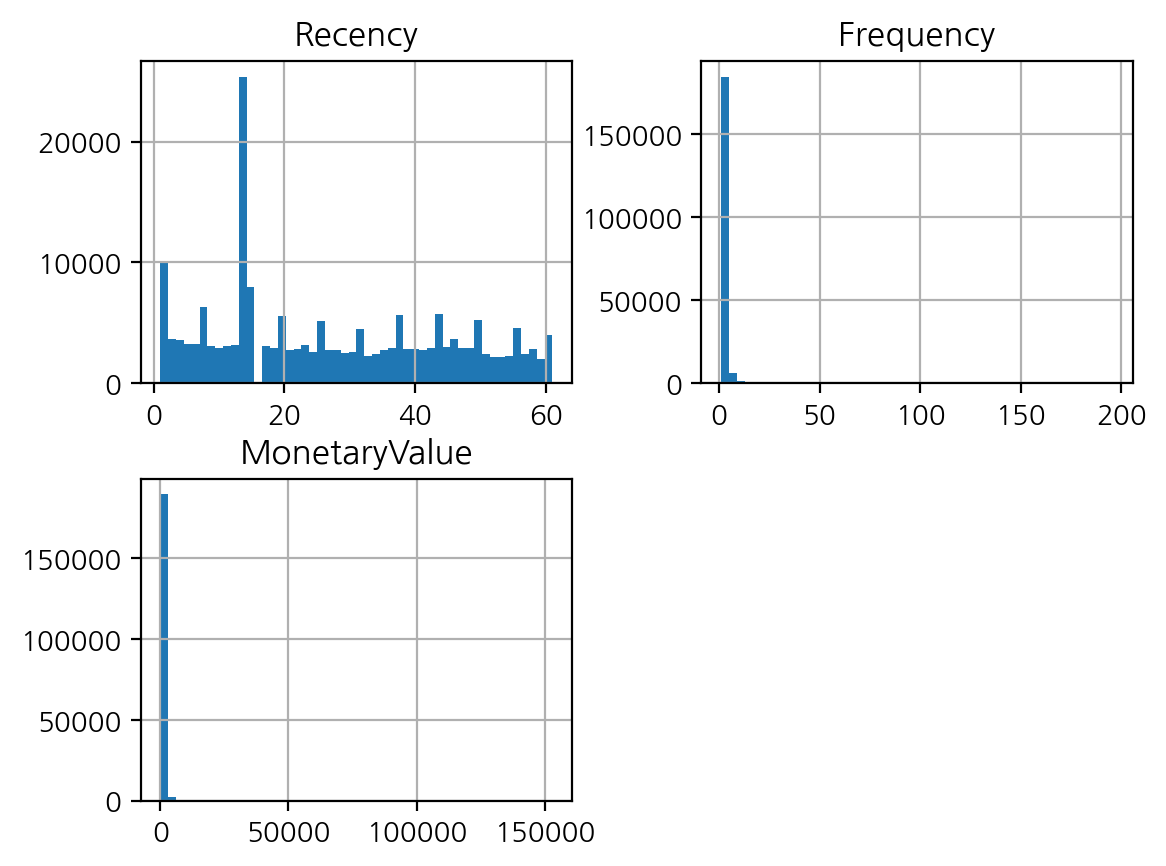

In [63]:
rfm.hist(bins=50);

In [64]:
rfm['Frequency'].describe()

count    192790.000000
mean          1.675663
std           2.417129
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         196.000000
Name: Frequency, dtype: float64

In [65]:
rfm[rfm['Frequency'] == 1].shape

(139870, 3)

### 고객당 매출

In [66]:
# user_id당 구매횟수 데이터프레임 만들기
buy_count = pd.DataFrame(raw['user_id'].value_counts())
buy_count.reset_index(inplace=True)
buy_count.columns = ['user_id', 'count']
buy_count.shape

(192790, 2)

In [67]:
buy_mon = pd.DataFrame(rfm['MonetaryValue'].sort_values())
buy_mon.reset_index(inplace=True)
buy_mon.columns = ['user_id', 'sum']
buy_mon.shape

(192790, 2)

In [68]:
customer_price = pd.merge(buy_mon, buy_count, how='left')
customer_price.shape

(192790, 3)

In [69]:
customer_price.tail(10)

,user_id,sum,count
192780,554842238,52515.019531,49
192781,514140124,55670.761719,29
192782,543312954,56035.671875,94
192783,549109608,66569.929688,140
192784,523974502,69742.078125,45
192785,545925192,75572.234375,61
192786,534545940,93547.781250,71
192787,564769842,101143.031250,60
192788,564068124,122690.000000,118
192789,530834332,152926.296875,59


In [70]:
customer_price.head(10)

,user_id,sum,count
0,536556662,1.26,1
1,512885998,1.26,1
2,515669546,1.26,1
3,538862728,1.26,1
4,513438427,1.26,1
5,513468837,1.26,1
6,565014969,1.26,1
7,536658266,1.26,1
8,555531863,1.26,1
9,554394278,1.26,1


### 고객당 주문 한건당 매출

In [71]:
customer_price['unitprice'] = customer_price['sum'] / customer_price['count']
customer_price.head()

,user_id,sum,count,unitprice
0,536556662,1.26,1,1.26
1,512885998,1.26,1,1.26
2,515669546,1.26,1,1.26
3,538862728,1.26,1,1.26
4,513438427,1.26,1,1.26


In [72]:
customer_price.tail()

,user_id,sum,count,unitprice
192785,545925192,75572.234375,61,1238.889088
192786,534545940,93547.781250,71,1317.574384
192787,564769842,101143.031250,60,1685.717187
192788,564068124,122690.000000,118,1039.745763
192789,530834332,152926.296875,59,2591.971133


In [73]:
# 구매 수가 1번 인 고객 : 139870명
len(customer_price[customer_price['count']==1])

139870

## RFM 모형

In [74]:
rfm.quantile(q = [0.25,0.5,0.75])

,Recency,Frequency,MonetaryValue
0.25,14.0,1.0,163.762493
0.50,24.0,1.0,265.099976
0.75,42.0,2.0,529.729980


In [75]:
quartiles = rfm.quantile(q = [0.25,0.5,0.75]).to_dict()
quartiles

{'Recency': {0.25: 14.0, 0.5: 24.0, 0.75: 42.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'MonetaryValue': {0.25: 163.76249313354492,
  0.5: 265.0999755859375,
  0.75: 529.72998046875}}

In [76]:
## for Recency 

def R(x, q, r):
    if x <= q[r][0.25]:
        return 4
    elif x <= q[r][0.50]:
        return 3
    elif x <= q[r][0.75]: 
        return 2
    else:
        return 1
    
## for Frequency and Monetary 

def FM(x,q,fm):
    if x <= q[fm][0.25]:
        return 1
    elif x <= q[fm][0.50]:
        return 2
    elif x <= q[fm][0.75]: 
        return 3
    else:
        return 4    

In [77]:
rfm['Recency'].apply(R, args=(quartiles, 'Recency'))
rfm['Frequency'].apply(FM, args=(quartiles, 'Frequency'))

user_id
315835876    1
366237542    1
389051600    1
403013066    1
415873351    1
            ..
579953265    1
579953464    1
579956024    1
579966375    1
579967058    1
Name: Frequency, Length: 192790, dtype: int64

In [78]:
#create RFM segmentation column
rfm['R_Quartile'] = rfm['Recency'].apply(R, args=(quartiles, 'Recency'))
rfm['F_Quartile'] = rfm['Frequency'].apply(FM, args=(quartiles, 'Frequency'))
rfm['M_Quartile'] = rfm['MonetaryValue'].apply(FM, args=(quartiles, 'MonetaryValue'))
rfm['RFM_segmentation'] = rfm.R_Quartile.map(str) \
                    + rfm.F_Quartile.map(str) \
                    + rfm.M_Quartile.map(str)
rfm['RFM_score'] = rfm.R_Quartile.map(int) + rfm.F_Quartile.map(int) + rfm.M_Quartile.map(int)
rfm.head()

,Recency,Frequency,MonetaryValue,R_Quartile,F_Quartile,M_Quartile,RFM_segmentation,RFM_score
user_id,,,,,,,,
315835876,7,1,169.889999,4,1,2,412,7
366237542,12,1,126.900002,4,1,1,411,6
389051600,20,1,229.910004,3,1,2,312,6
403013066,44,1,229.220001,1,1,2,112,4
415873351,31,1,263.059998,2,1,2,212,5


### 가중치 탐색
- 김동석 (2021). RFM 모형의 가중치 선택에 관한 연구. 제주대학교. 석사학위논문 참고함
- RFM 점수에서 상위 20% 고객들의 평균값 vs. 전체 자료의 R, F, M의 상위 20%의 고객들의 평균값을 비교
- 가장 유사한 값 구하기

In [79]:
# R 상위 20% 고객 비교
total_RFM = rfm.sort_values(by='Recency', ascending=False) 
L = int(len(total_RFM) * 0.2)
R_mean = total_RFM['Recency'][:L].mean()
R_mean

53.039473001711706

In [80]:
# F 상위 20% 고객 비교
total_RFM = rfm.sort_values(by='Frequency', ascending=False) 
L = int(len(total_RFM) * 0.2)
F_mean = total_RFM['Frequency'][:L].mean()
F_mean

4.005835364904819

In [81]:
# M 상위 20% 고객 비교
total_RFM = rfm.sort_values(by='MonetaryValue', ascending=False) 
L = int(len(total_RFM) * 0.2)
M_mean = total_RFM['MonetaryValue'][:L].mean()
M_mean

1586.2677001953125

In [82]:
rfm_diff = rfm.copy()

In [83]:
a_r = 0.7
b_f = 0.1
c_m = 0.2
rfm_diff['RFM_score'] = a_r* rfm_diff.R_Quartile.map(int) + b_f *rfm_diff.F_Quartile.map(int) + c_m*rfm_diff.M_Quartile.map(int)

In [84]:
# RFM_score 상위 20% 고객 비교
top_score = rfm_diff.sort_values(by='RFM_score', ascending=False) 
L = int(len(top_score) * 0.2)
diff = top_score[['Recency','Frequency','MonetaryValue']][:L].mean()
diff

Recency             8.706416
Frequency           2.736682
MonetaryValue    1017.906311
dtype: float64

In [85]:
# 차이가 가장 적은 값을 구하기
(diff['Recency'] / R_mean) + (diff['Frequency'] / F_mean) + (diff['MonetaryValue'] / M_mean)

1.489022655045729

In [86]:
rfm = rfm_diff

In [87]:
rfm.groupby('RFM_score').agg({'Recency' : 'mean',
                              'Frequency' : 'mean',
                              'MonetaryValue' : ['mean','sum']
                             }).style.background_gradient().format('{:,.0f}')

### qcut으로 고객군 나누기

In [88]:
# qcut 을 통해 5단계로 고객군을 나눕니다. 
rfm['RFM_class'] = pd.qcut(rfm['RFM_score'],
                           q=5,
                           labels=['Lost', 'About To Sleep', 'Silver','GOLD','VVIP'])

In [89]:
rfm

,Recency,Frequency,MonetaryValue,R_Quartile,F_Quartile,M_Quartile,RFM_segmentation,RFM_score,RFM_class
user_id,,,,,,,,,
315835876,7,1,169.889999,4,1,2,412,3.3,GOLD
366237542,12,1,126.900002,4,1,1,411,3.1,GOLD
389051600,20,1,229.910004,3,1,2,312,2.6,Silver
403013066,44,1,229.220001,1,1,2,112,1.2,Lost
415873351,31,1,263.059998,2,1,2,212,1.9,About To Sleep
...,...,...,...,...,...,...,...,...,...
579953265,1,1,1544.160034,4,1,4,414,3.7,VVIP
579953464,1,1,124.110001,4,1,1,411,3.1,GOLD
579956024,1,1,282.089996,4,1,3,413,3.5,VVIP


### RFM 시각화

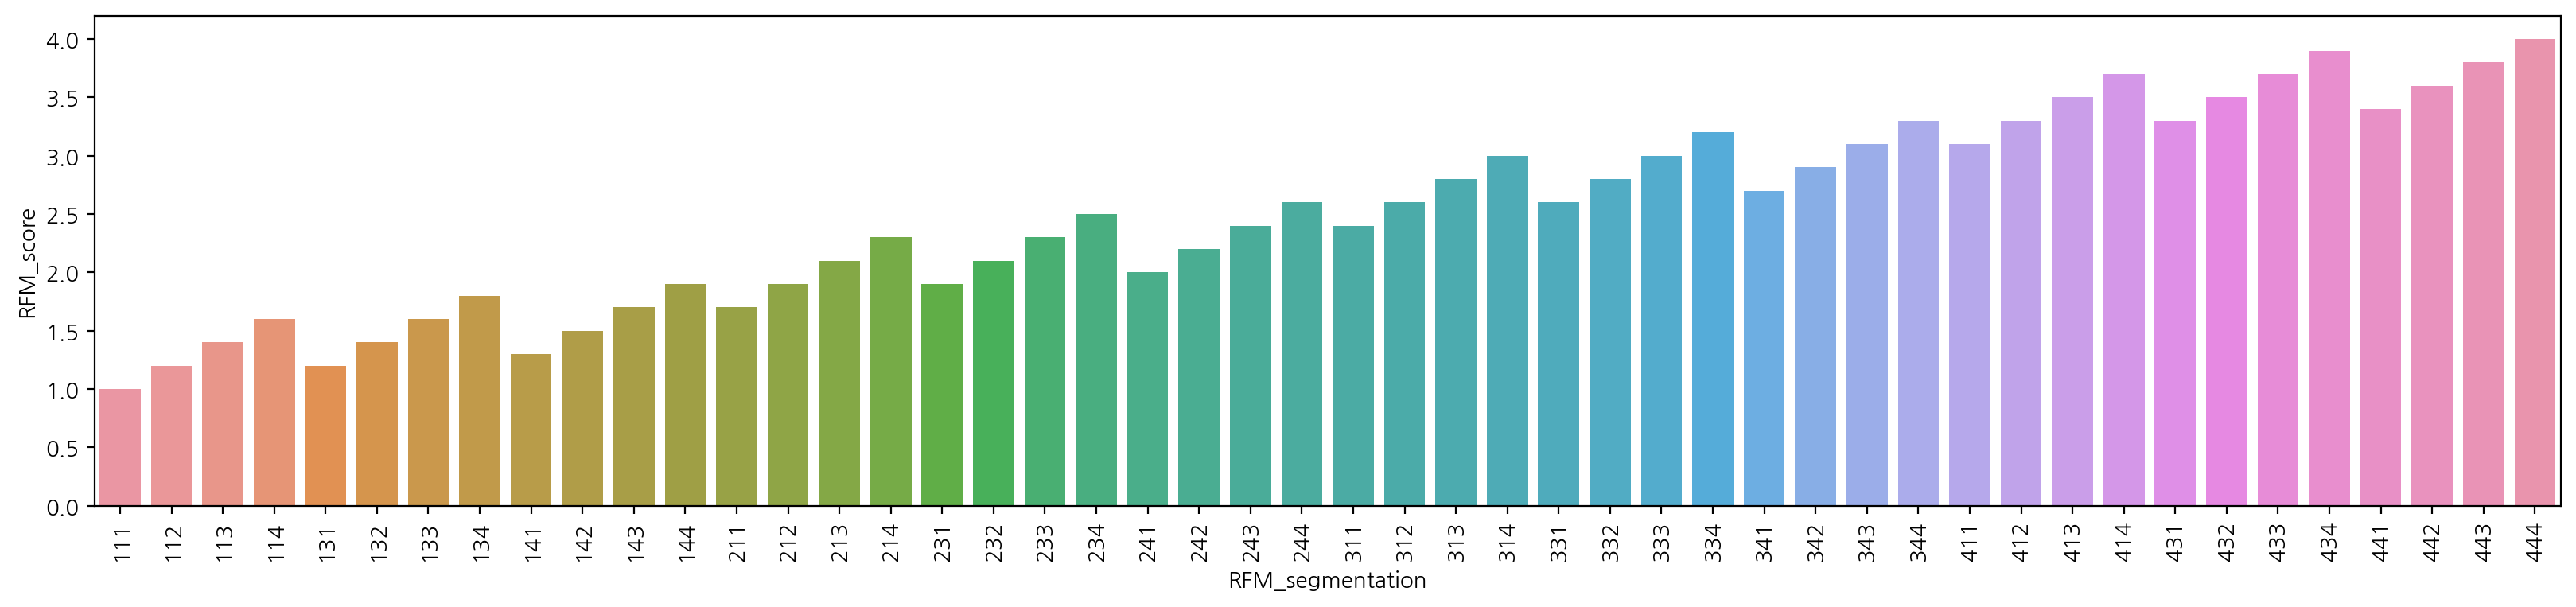

In [90]:
# RFM segment 값에 따라 정렬합니다.
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.barplot(data=rfm.sort_values('RFM_segmentation'), x='RFM_segmentation', y='RFM_score');

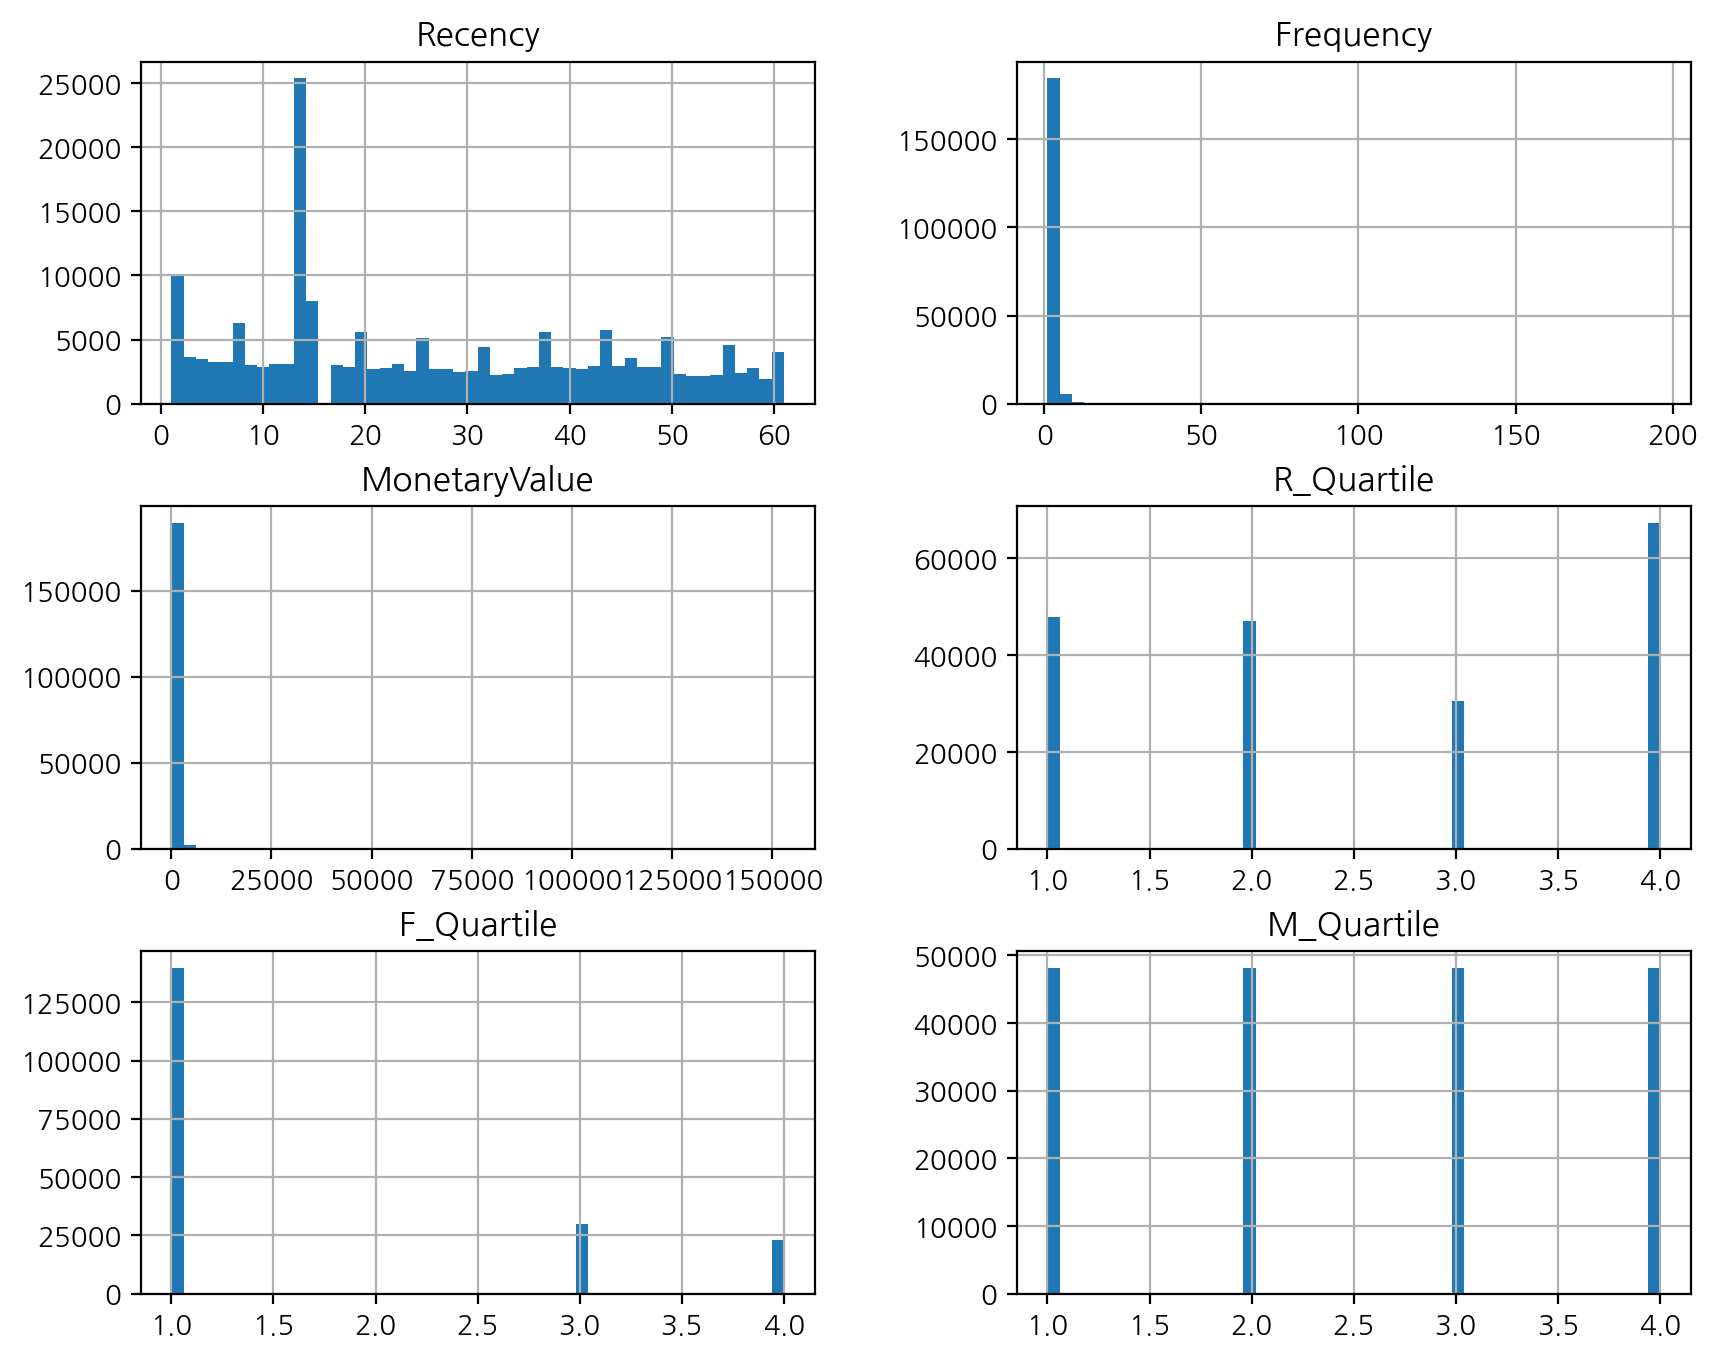

In [91]:
rfm.iloc[:, :-3].astype(float).hist(figsize=(10,8), bins=50);

### 고객 등급 나누기

In [92]:
# 각 등급별 크기를 구해보자.
RFM_desc = rfm.groupby('RFM_class').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count', 'sum']
}).round(1)

RFM_desc.style.background_gradient(cmap='Blues').format('{:,.0f}')

In [93]:
RFM = rfm[['Recency','Frequency','MonetaryValue','RFM_score','RFM_class']].copy()
RFM

,Recency,Frequency,MonetaryValue,RFM_score,RFM_class
user_id,,,,,
315835876,7,1,169.889999,3.3,GOLD
366237542,12,1,126.900002,3.1,GOLD
389051600,20,1,229.910004,2.6,Silver
403013066,44,1,229.220001,1.2,Lost
415873351,31,1,263.059998,1.9,About To Sleep
...,...,...,...,...,...
579953265,1,1,1544.160034,3.7,VVIP
579953464,1,1,124.110001,3.1,GOLD
579956024,1,1,282.089996,3.5,VVIP


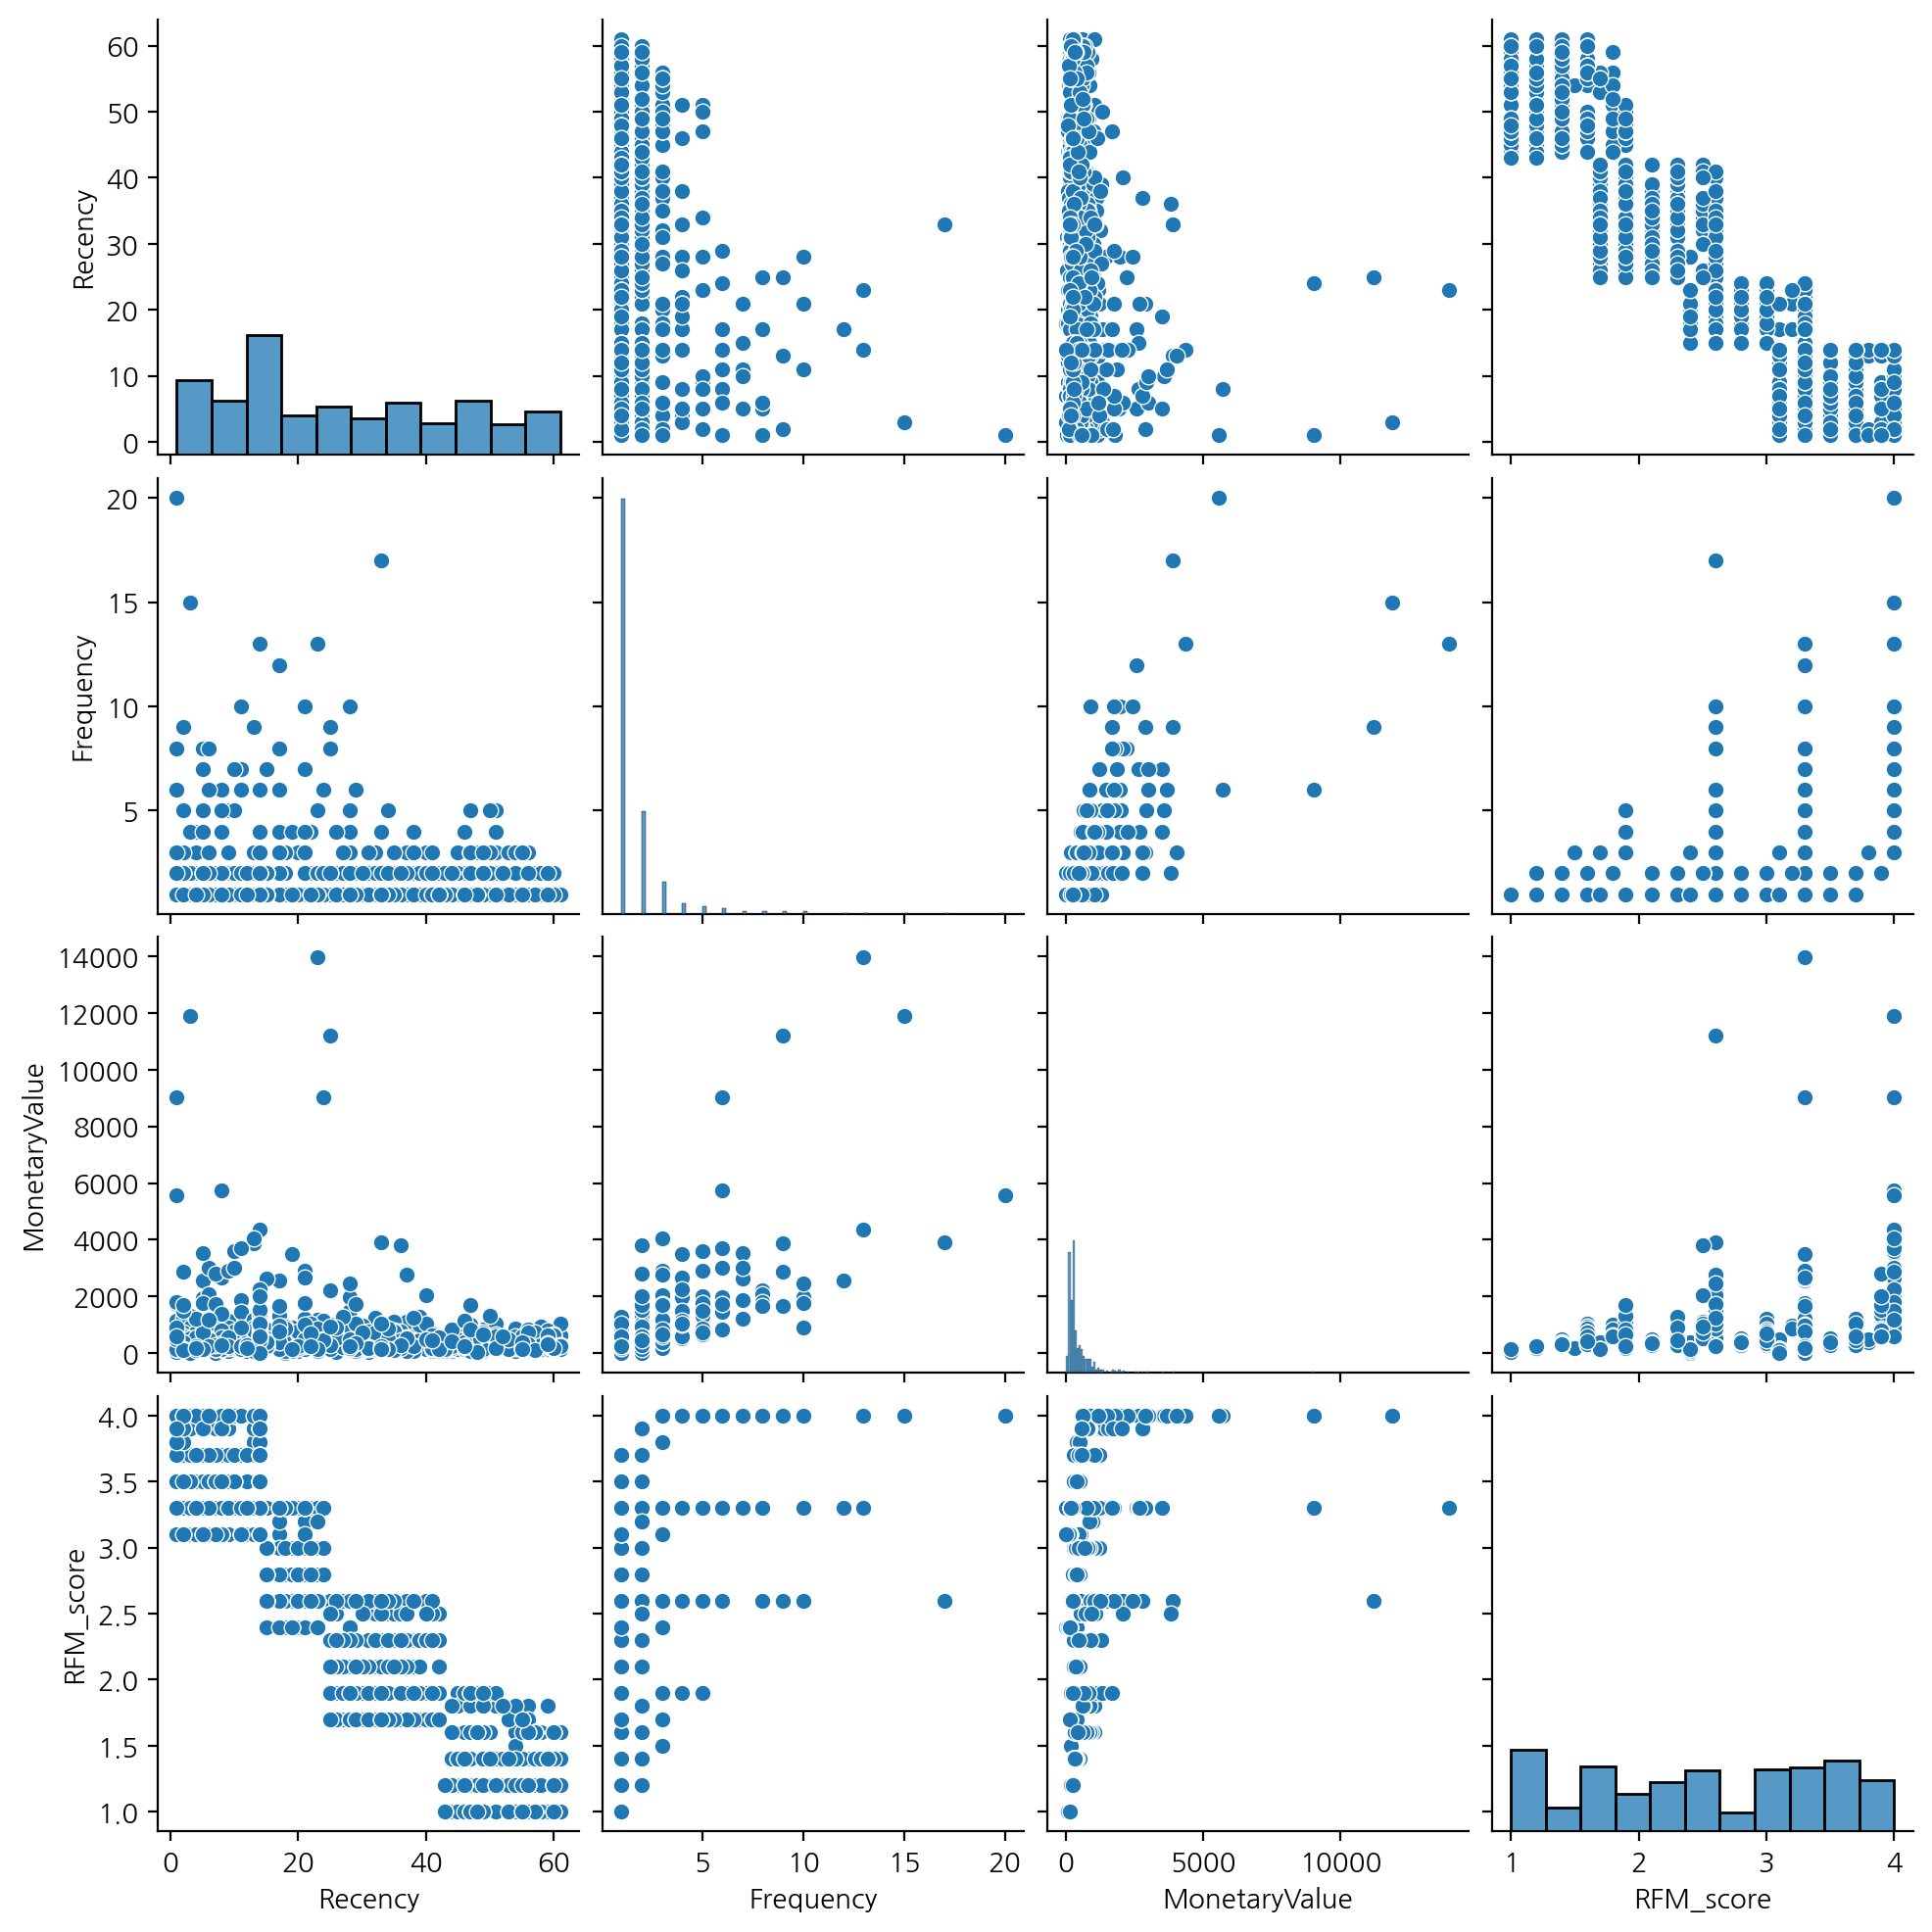

In [94]:
sns.pairplot(data=RFM.sample(1000), diag_kind='hist');

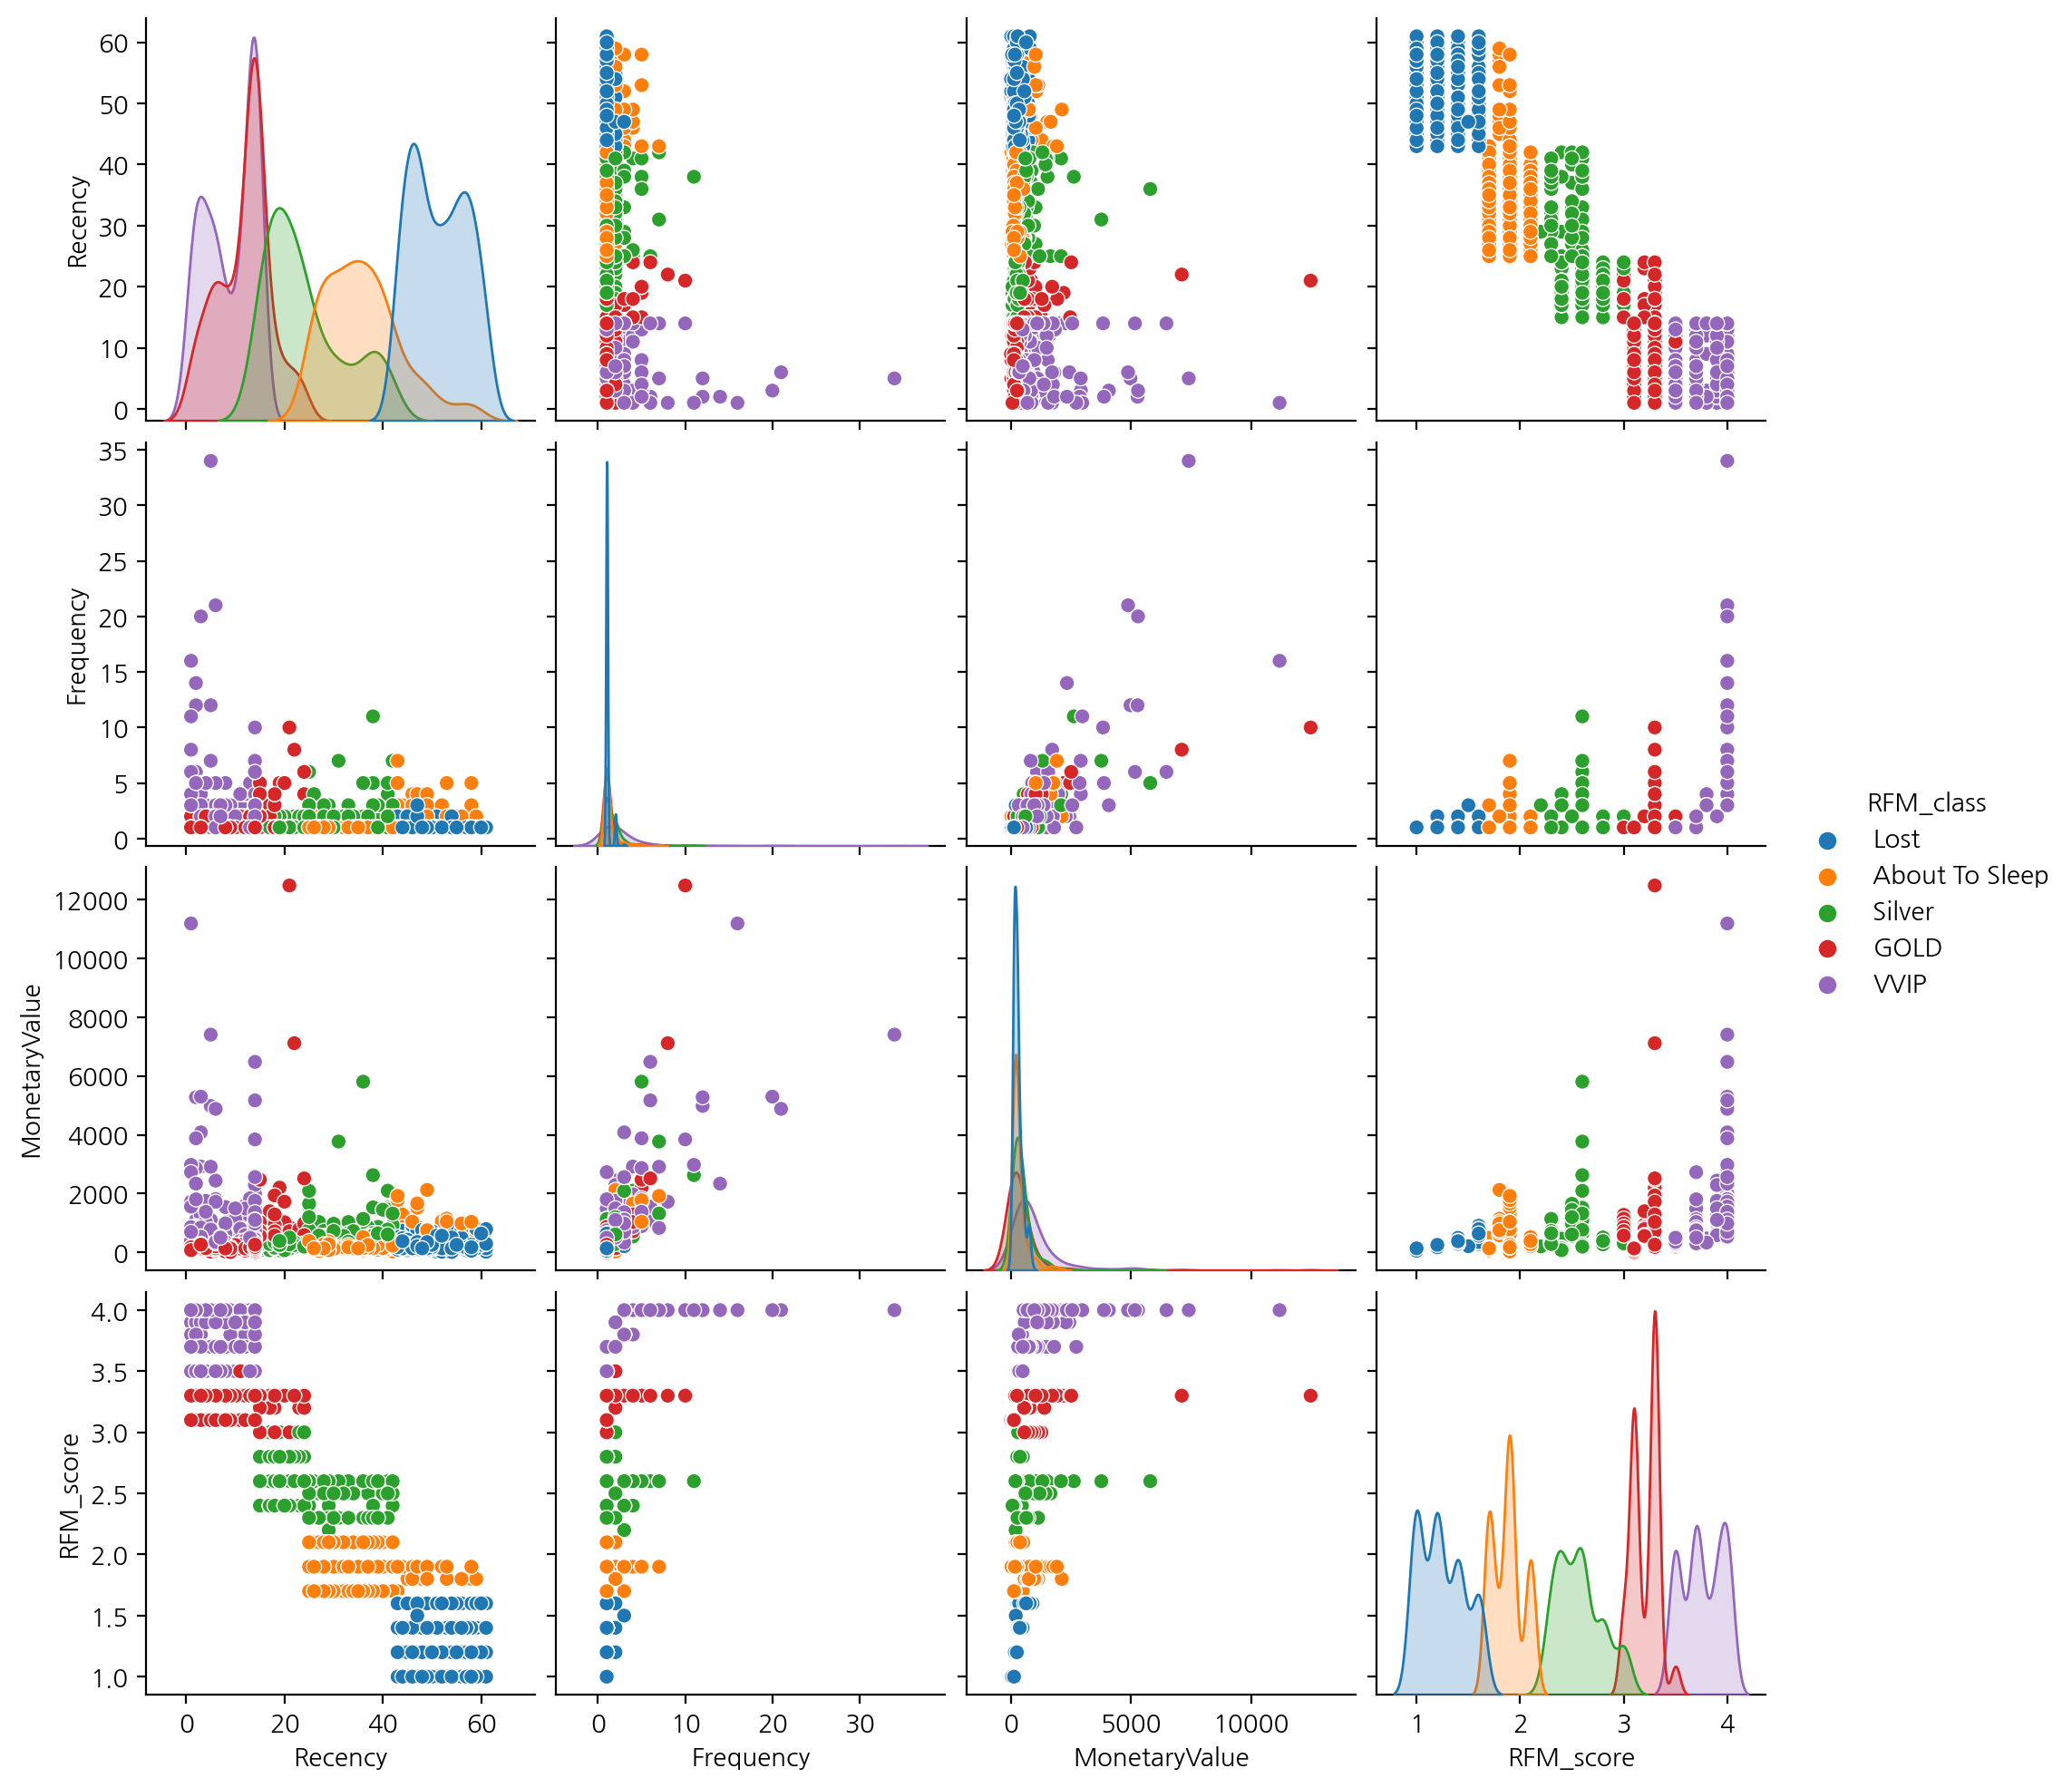

In [95]:
sns.pairplot(data=RFM.sample(1000), hue='RFM_class');

In [96]:
corr_RFM = RFM.corr()
corr_RFM

,Recency,Frequency,MonetaryValue,RFM_score
Recency,1.000000,-0.128147,-0.096155,-0.910597
Frequency,-0.128147,1.000000,0.744517,0.238097
MonetaryValue,-0.096155,0.744517,1.000000,0.206769
RFM_score,-0.910597,0.238097,0.206769,1.000000


In [97]:
mask = np.triu(np.ones_like(corr_RFM))

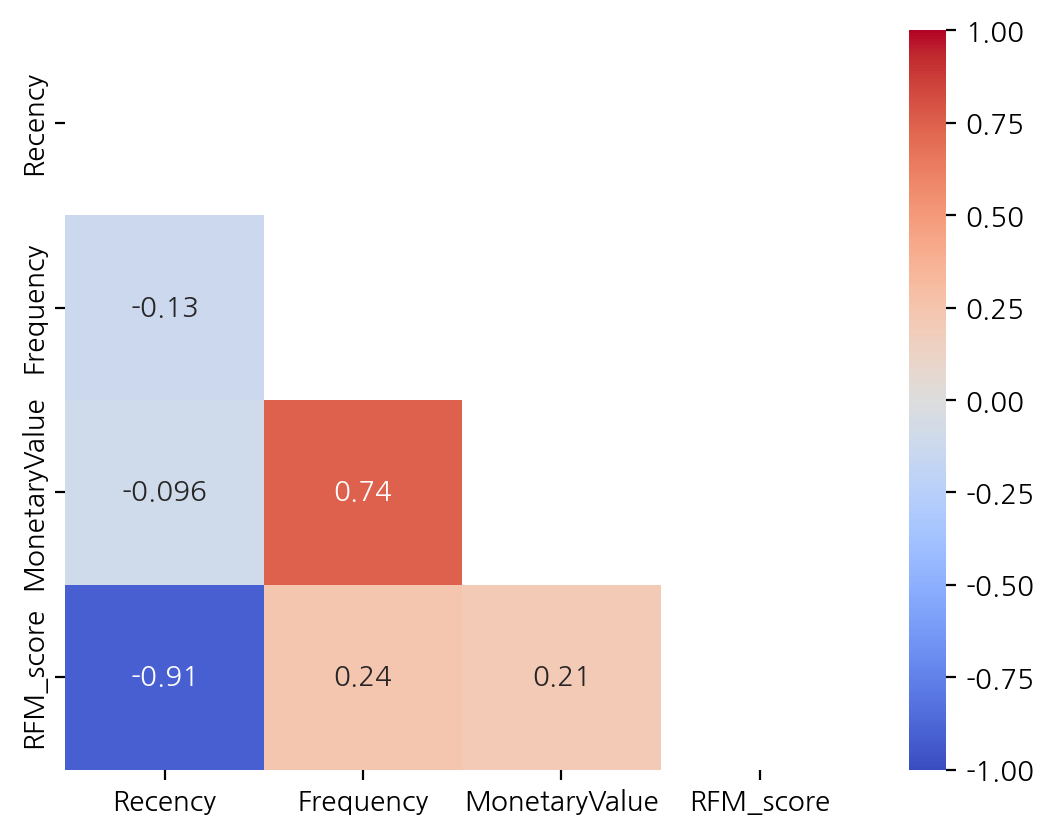

In [98]:
# 상관관계를 열분포 형태의 이미지로 보여주는 heatmap 으로 데이터 시각화합니다.
sns.heatmap(corr_RFM, annot=True, cmap="coolwarm", vmin=-1, vmax=1, mask=mask);

In [99]:
# 컬럼 층위를 제거하고 이름을 다시 붙여봅니다.
RFM_desc.columns = RFM_desc.columns.droplevel()
RFM_desc.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count','Sum']

In [100]:
# 색 팔레트 지정
colors=['red','pink','silver','y','Gold']

### 고객 등급별 매출액

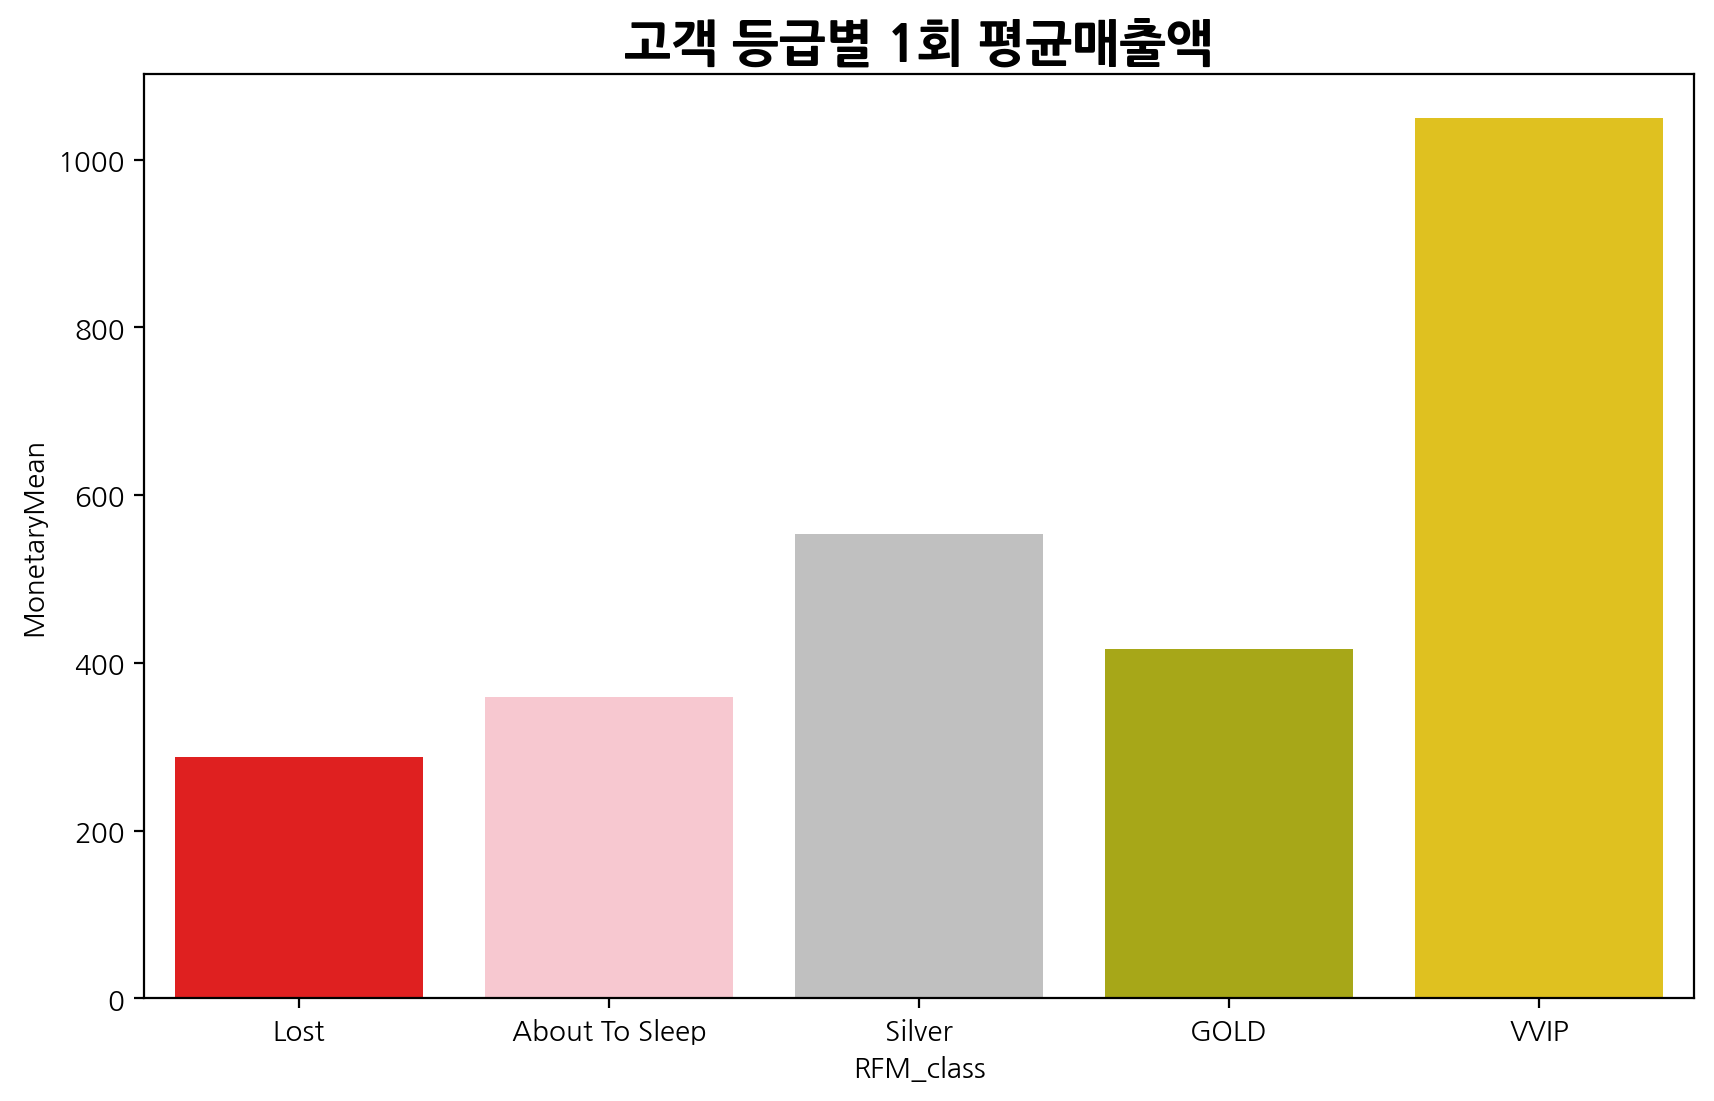

In [101]:
# 고객 등급별 매출 평균
plt.figure(figsize=(10, 6))
sns.set_palette(sns.color_palette(colors))

sns.barplot(data=RFM_desc, x=RFM_desc.index, y='MonetaryMean')
plt.title('고객 등급별 1회 평균매출액', fontsize=18, fontweight='bold');

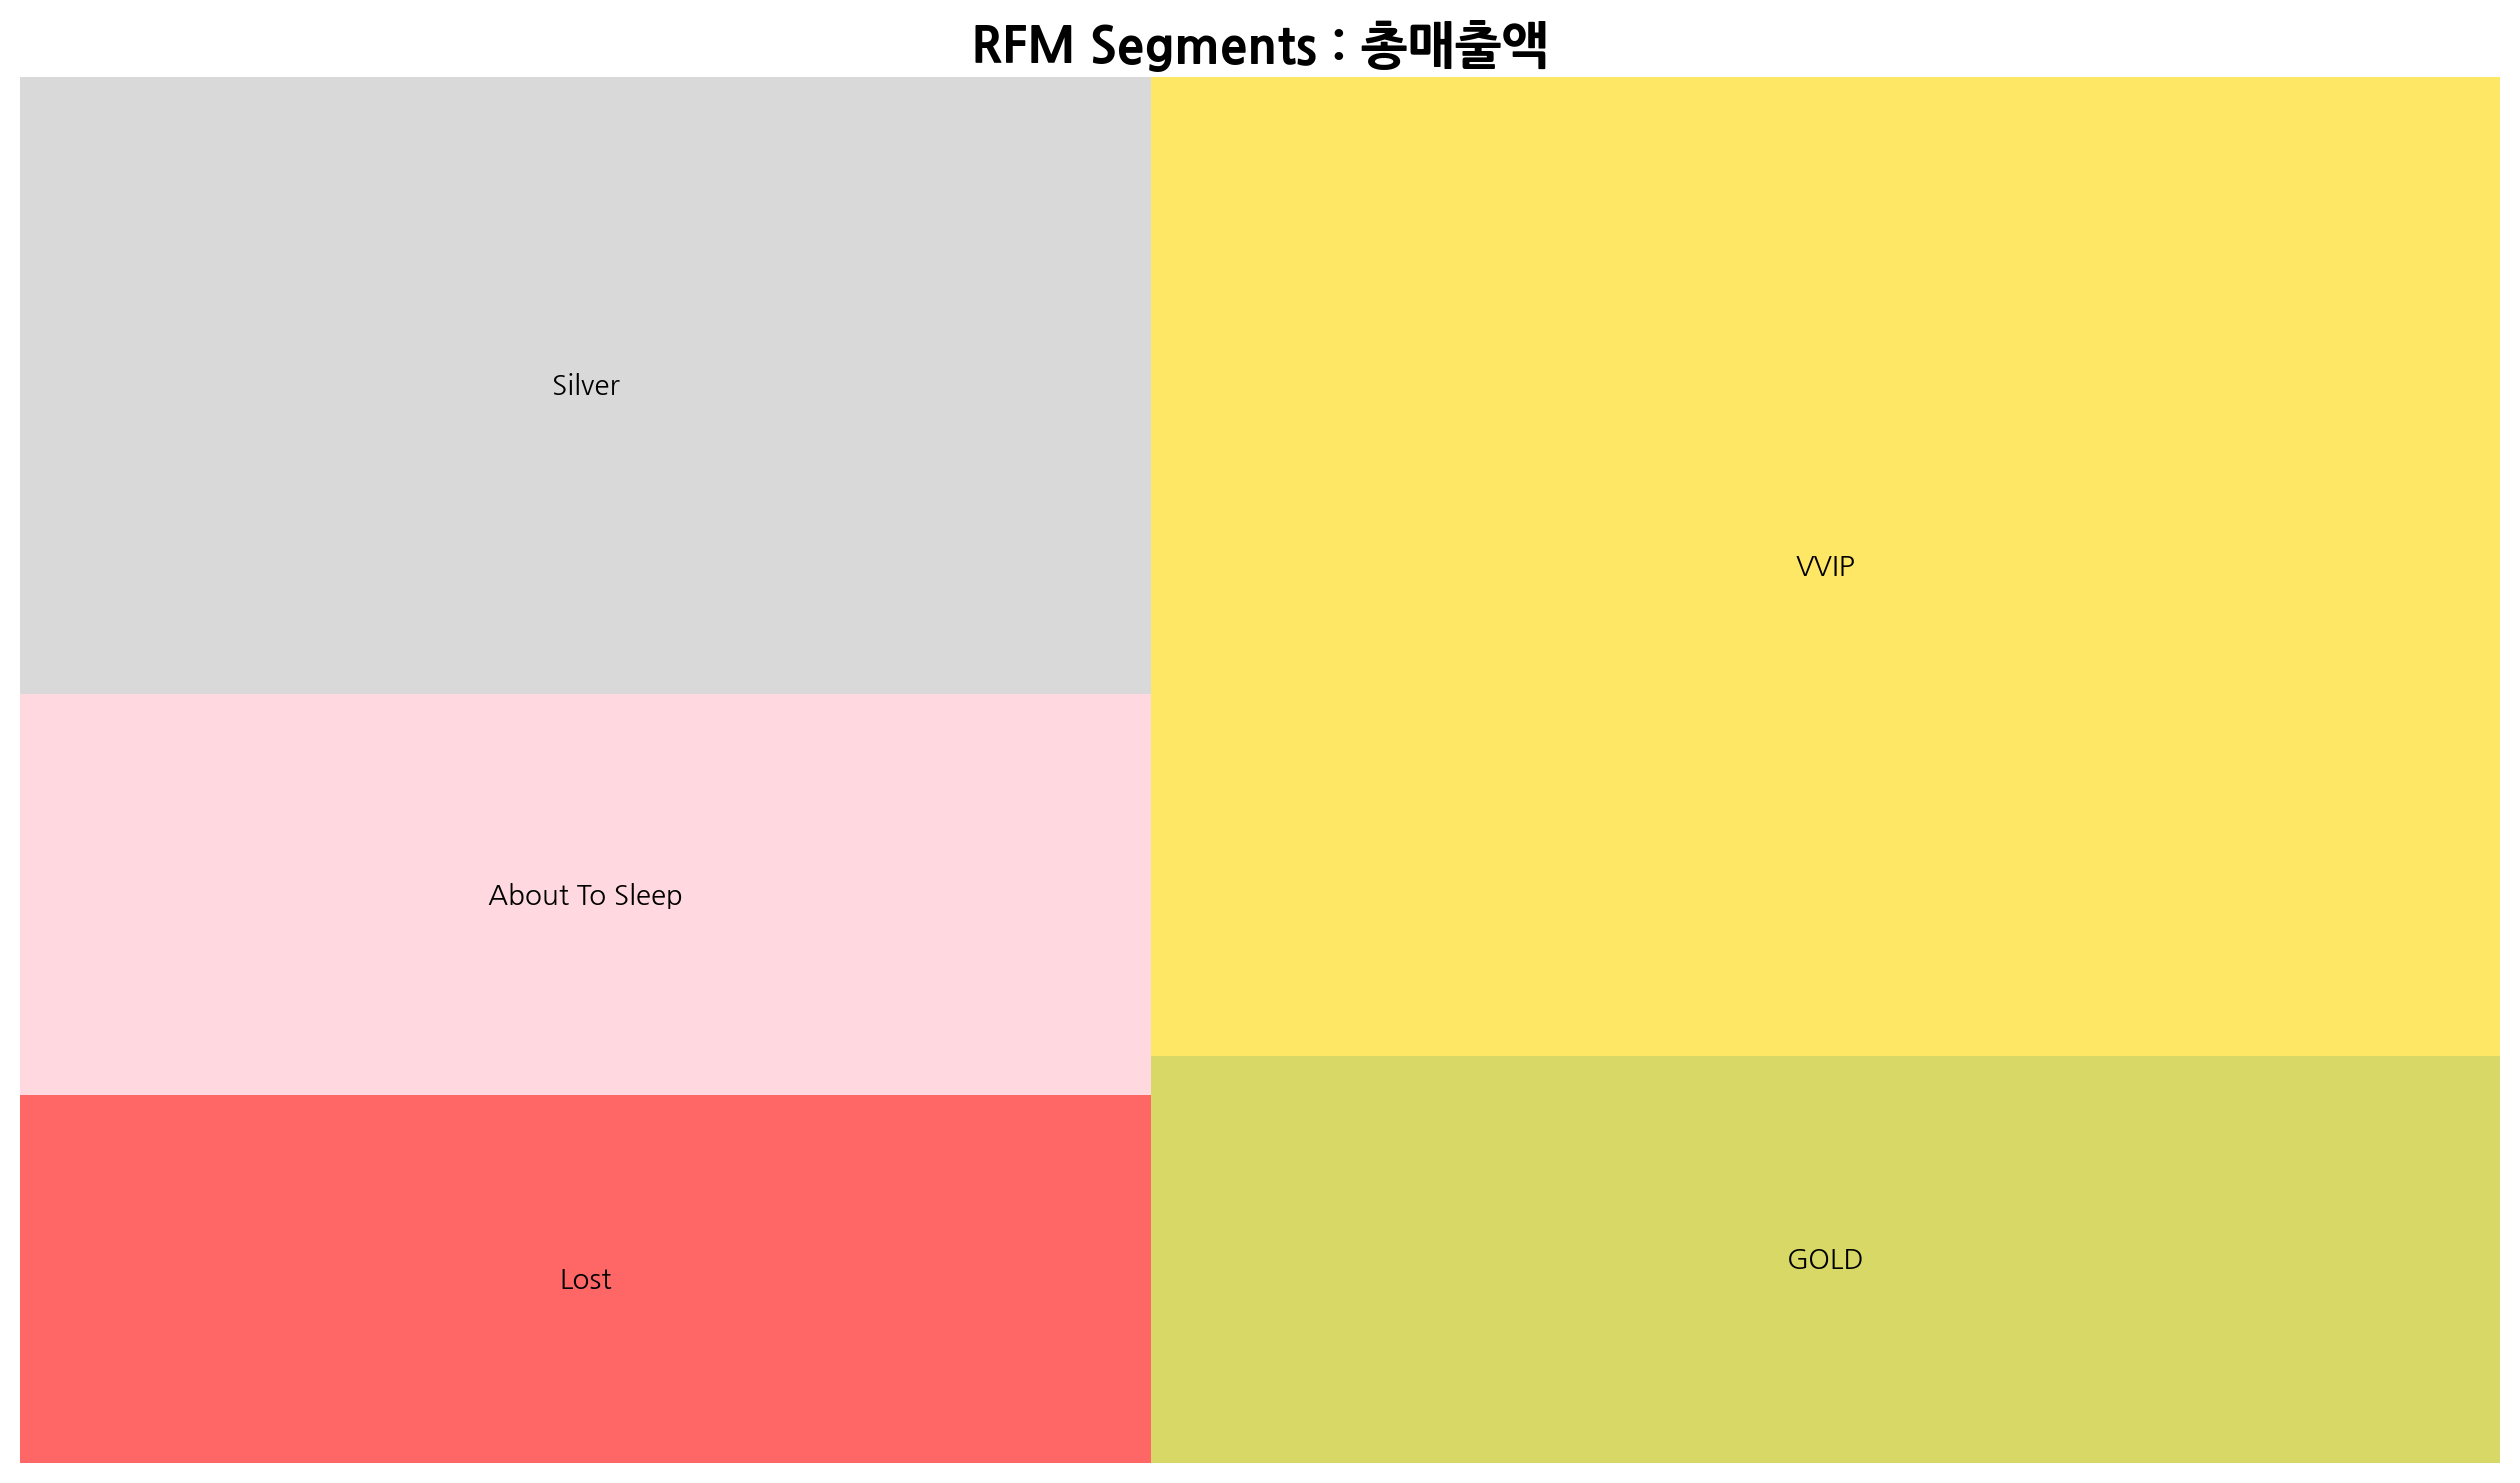

In [102]:
# 그려봅시다
fig = plt.gcf()
ax = fig.add_subplot()
label=['Lost', 'About To Sleep', 'Silver', 'GOLD', 'VVIP']
color=colors

fig.set_size_inches(16, 9)
squarify.plot(sizes=RFM_desc['Sum'], 
              label=label, color=color, alpha=.6 )
plt.title('RFM Segments : 총매출액',fontsize=18, fontweight='bold')
plt.axis('off')
plt.show();

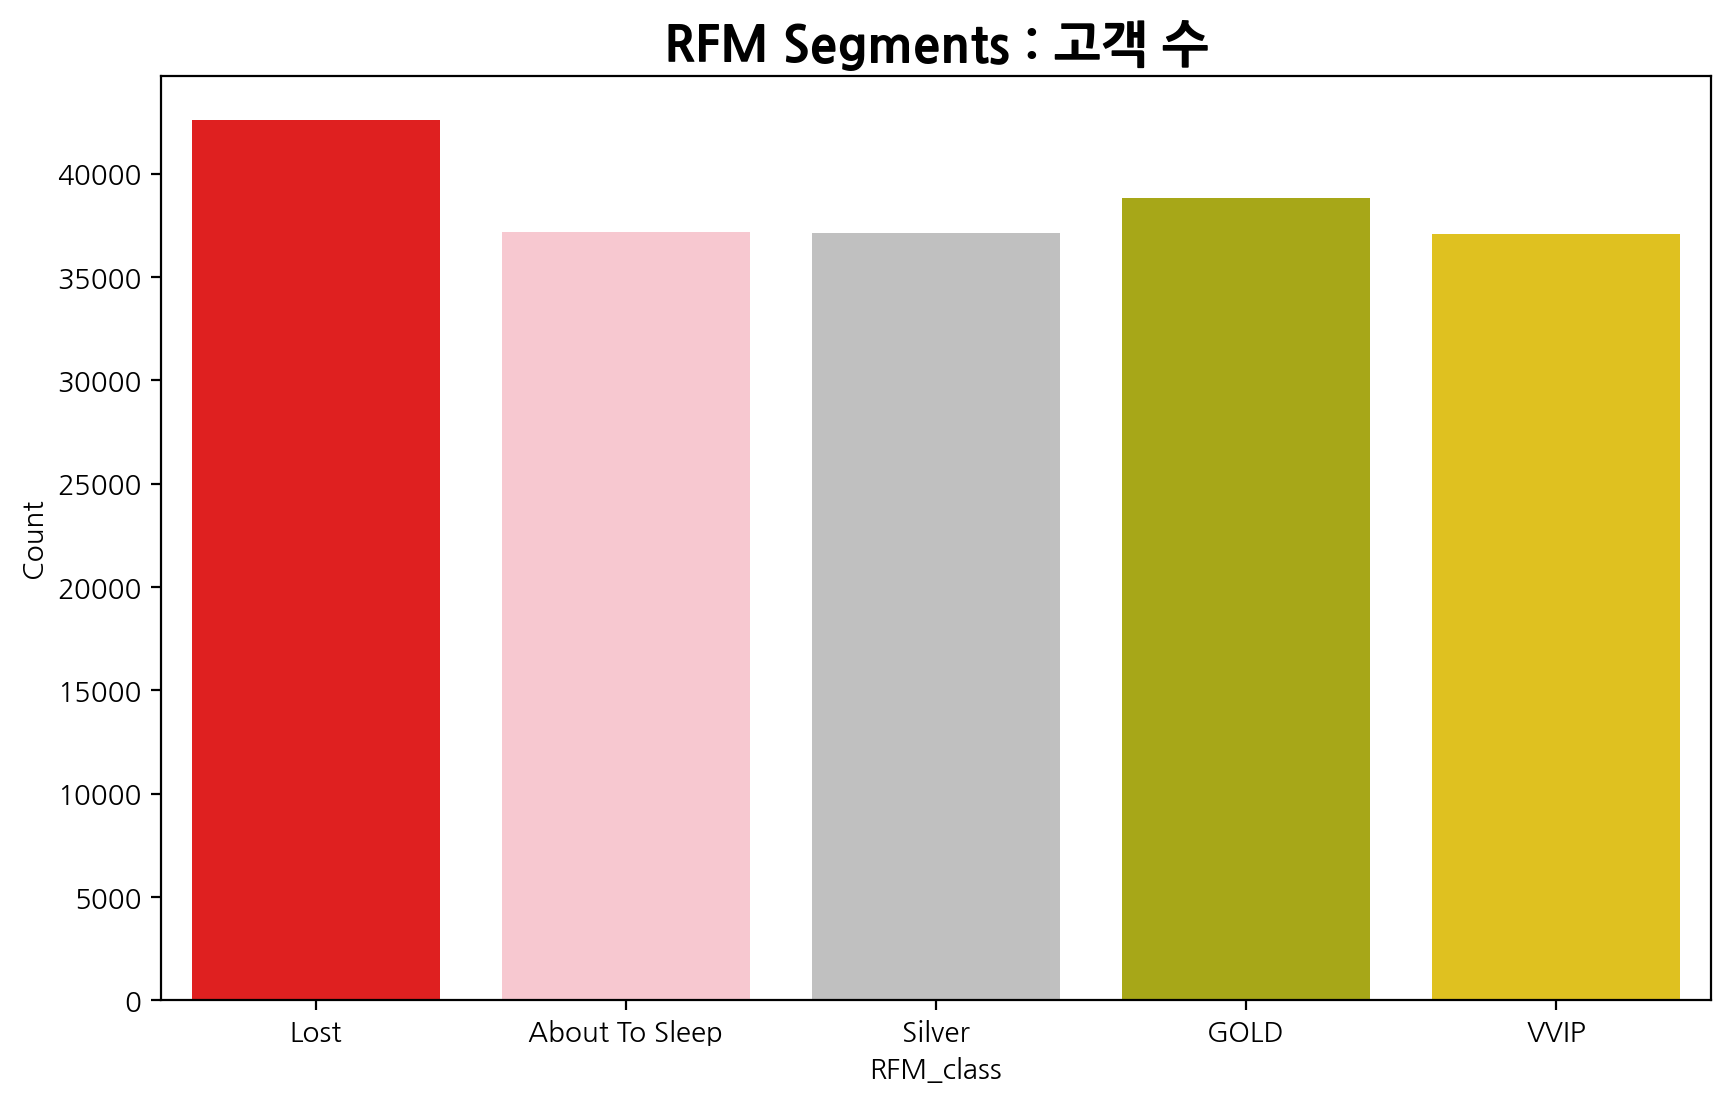

In [103]:
plt.figure(figsize=(10, 6))
sns.set_palette(sns.color_palette(colors))

sns.barplot(data=RFM_desc, x=RFM_desc.index, y='Count')
plt.title('RFM Segments : 고객 수', fontsize=18,fontweight='bold')
plt.show()

## VVIP의 매출 추이

In [104]:
# RFM_class를 user_id 기준으로 user_session 그룹화한 raw 데이터에 추가하기
raw

,Date_order,user_id,Quantity,spent
0,2019-10-06 11:34:30,546521725,1,289.519989
1,2019-10-25 08:39:11,560486342,1,171.899994
2,2019-11-11 03:35:34,566954797,1,151.610001
3,2019-10-24 09:08:58,513622224,1,131.509995
4,2019-10-19 11:15:20,561610048,2,422.000000
...,...,...,...,...
323046,2019-11-11 11:02:45,530408758,1,243.509995
323047,2019-11-05 04:54:08,516516131,1,170.070007
323048,2019-11-17 14:47:28,521378371,1,269.970001
323049,2019-11-24 08:34:23,513821974,1,977.859985


In [105]:
# id별 class
id_class = rfm[['RFM_class']]
id_class

,RFM_class
user_id,
315835876,GOLD
366237542,GOLD
389051600,Silver
403013066,Lost
415873351,About To Sleep
...,...
579953265,VVIP
579953464,GOLD
579956024,VVIP


In [106]:
# 기존 데이터에 클래스 더하기
raw_class = pd.merge(raw, id_class, on='user_id', how='left')
raw_class

,Date_order,user_id,Quantity,spent,RFM_class
0,2019-10-06 11:34:30,546521725,1,289.519989,VVIP
1,2019-10-25 08:39:11,560486342,1,171.899994,Silver
2,2019-11-11 03:35:34,566954797,1,151.610001,GOLD
3,2019-10-24 09:08:58,513622224,1,131.509995,About To Sleep
4,2019-10-19 11:15:20,561610048,2,422.000000,Silver
...,...,...,...,...,...
323046,2019-11-11 11:02:45,530408758,1,243.509995,Silver
323047,2019-11-05 04:54:08,516516131,1,170.070007,Silver
323048,2019-11-17 14:47:28,521378371,1,269.970001,VVIP
323049,2019-11-24 08:34:23,513821974,1,977.859985,VVIP


In [107]:
# vvip만 뽑아오기
vvip = raw_class[raw_class['RFM_class']=='VVIP']
vvip = vvip.reset_index(drop=True)
vvip

,Date_order,user_id,Quantity,spent,RFM_class
0,2019-10-06 11:34:30,546521725,1,289.519989,VVIP
1,2019-10-18 10:46:20,548449052,2,499.720001,VVIP
2,2019-11-22 04:29:15,574429172,2,492.000000,VVIP
3,2019-11-27 15:47:11,570854273,2,176.520004,VVIP
4,2019-10-15 07:23:45,514359367,1,172.190002,VVIP
...,...,...,...,...,...
102520,2019-11-16 11:50:54,556215389,1,579.140015,VVIP
102521,2019-11-25 04:35:57,572195290,1,88.260002,VVIP
102522,2019-11-09 03:02:22,537797654,1,238.669998,VVIP
102523,2019-11-17 14:47:28,521378371,1,269.970001,VVIP


In [108]:
# 날짜 부분 변경 시간대 제거
vvip['Date_order'] = vvip['Date_order'].dt.strftime('%F')
vvip

,Date_order,user_id,Quantity,spent,RFM_class
0,2019-10-06,546521725,1,289.519989,VVIP
1,2019-10-18,548449052,2,499.720001,VVIP
2,2019-11-22,574429172,2,492.000000,VVIP
3,2019-11-27,570854273,2,176.520004,VVIP
4,2019-10-15,514359367,1,172.190002,VVIP
...,...,...,...,...,...
102520,2019-11-16,556215389,1,579.140015,VVIP
102521,2019-11-25,572195290,1,88.260002,VVIP
102522,2019-11-09,537797654,1,238.669998,VVIP
102523,2019-11-17,521378371,1,269.970001,VVIP


## 일별 vvip 매출액, 구매량, 방문수

In [109]:
vvip_day = vvip.groupby(['Date_order']).agg(매출액=('spent','sum'), 
                                 구매량=('Quantity','sum'),
                                 방문수=('user_id','count'))

vvip_day.head()

,매출액,구매량,방문수
Date_order,,,
2019-10-01,152031.343750,508,408
2019-10-02,166367.859375,569,443
2019-10-03,163019.625000,573,478
2019-10-04,208290.015625,720,596
2019-10-05,169336.765625,572,462


In [110]:
vvip_day.describe()

,매출액,구매량,방문수
count,6.000000e+01,60.000000,60.000000
mean,6.480776e+05,2091.466667,1708.750000
std,1.119206e+06,3089.604272,2554.388398
min,1.520313e+05,498.000000,408.000000
25%,2.339268e+05,869.000000,714.000000
50%,2.995353e+05,1006.000000,831.000000
75%,5.571080e+05,1957.750000,1535.500000
max,8.434307e+06,22875.000000,18931.000000


In [111]:
q1 = vvip_day['방문수'].quantile(0.25)
q2 = vvip_day['방문수'].quantile(0.5)
q3 = vvip_day['방문수'].quantile(0.75)
iqr = q3 - q1
iqr

outliers_vip = vvip_day[['방문수']][(vvip_day['방문수'] < (q1 - 1.5 * iqr)) | (vvip_day['방문수'] > (q3 + 1.5 * iqr))]
outliers_vip.sort_values(by=['방문수'])

,방문수
Date_order,
2019-11-25,3237
2019-11-23,3289
2019-11-24,3332
2019-11-21,3375
2019-11-26,3383
2019-11-22,3434
2019-11-28,3443
2019-11-20,3499
2019-11-27,3526


In [112]:
vvip_day = vvip_day[vvip_day['방문수'] < 3237]
vvip_day.head()

,매출액,구매량,방문수
Date_order,,,
2019-10-01,152031.343750,508,408
2019-10-02,166367.859375,569,443
2019-10-03,163019.625000,573,478
2019-10-04,208290.015625,720,596
2019-10-05,169336.765625,572,462


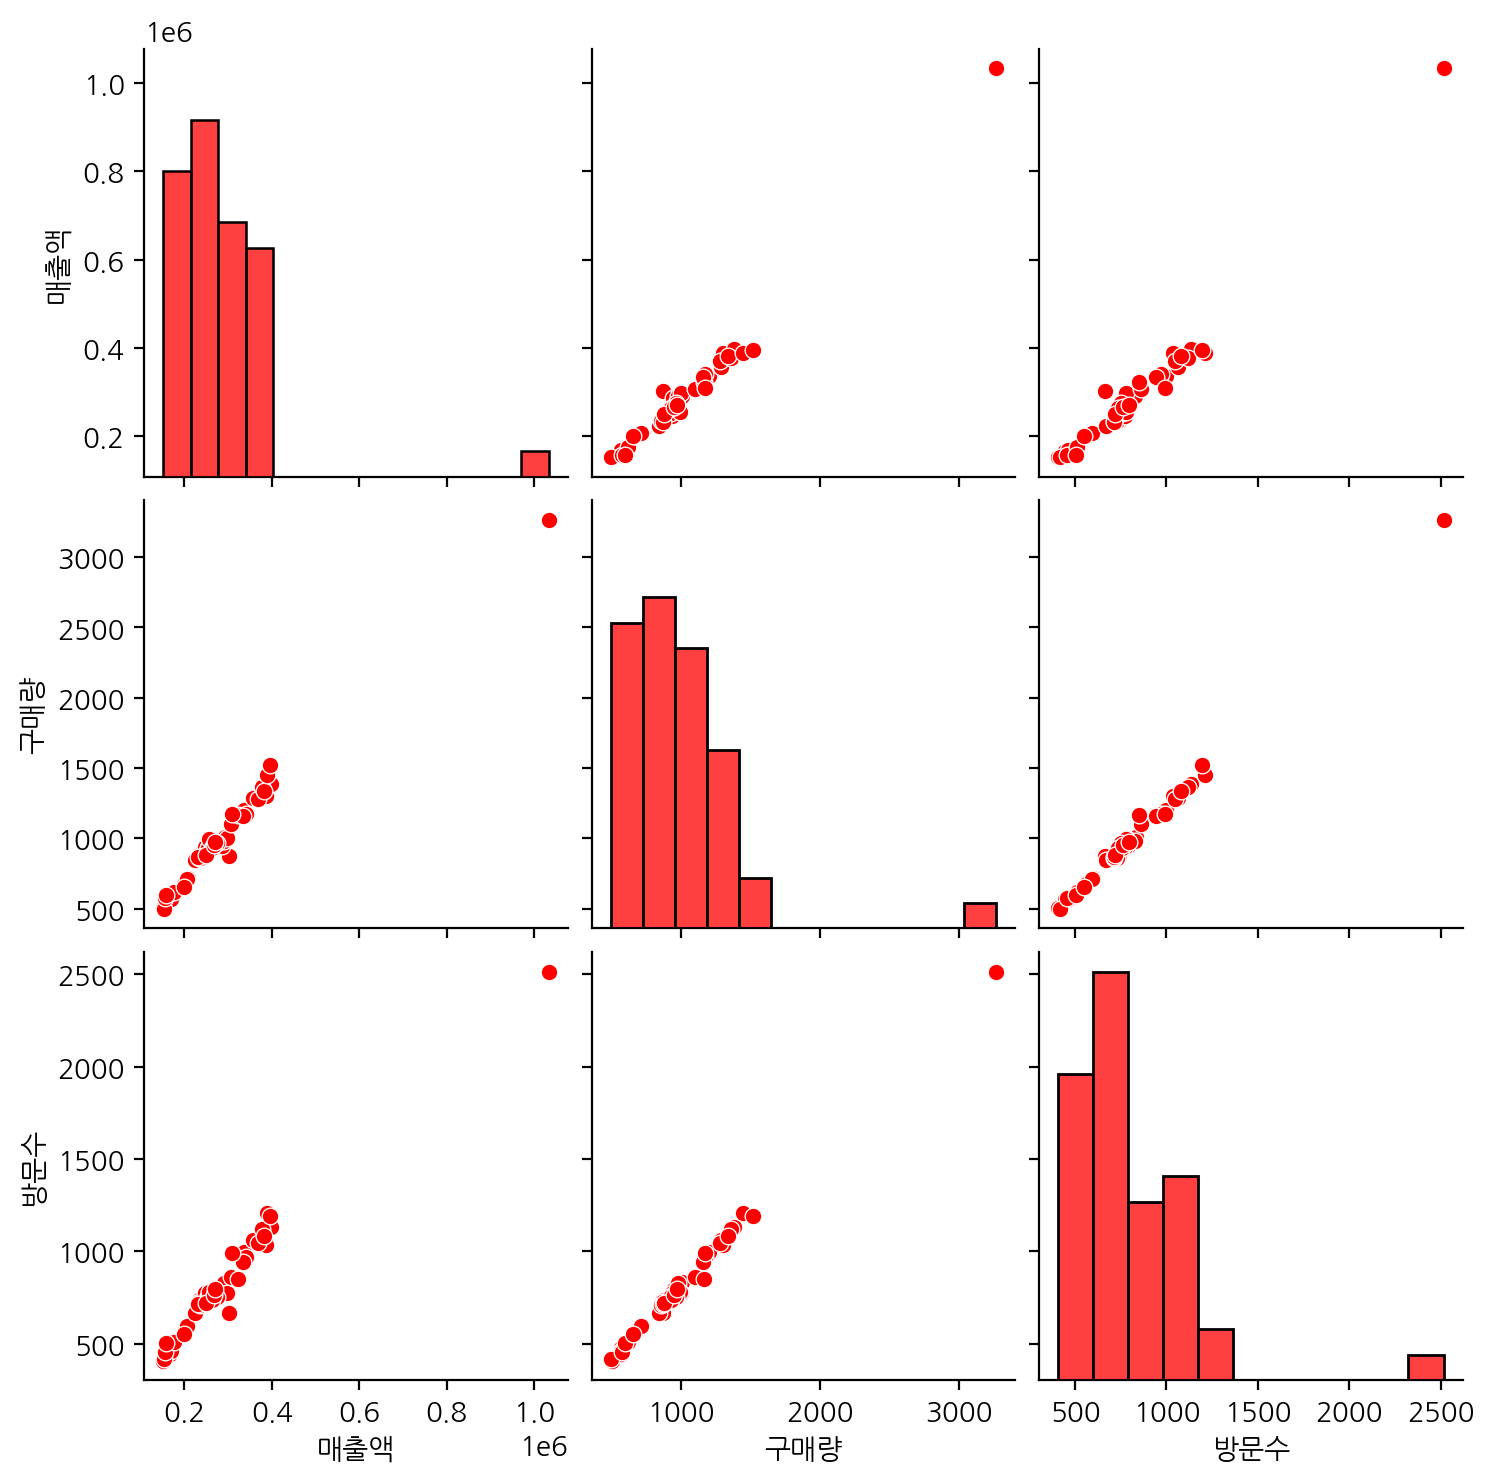

In [113]:
sns.pairplot(vvip_day, diag_kind='hist');

In [114]:
vvip_day[vvip_day['매출액'] == vvip_day['매출액'].max()]

,매출액,구매량,방문수
Date_order,,,
2019-11-16,1033027.5,3265,2515


In [115]:
vvip_day = vvip_day[vvip_day['방문수'] < 2500]
vvip_day.head()

,매출액,구매량,방문수
Date_order,,,
2019-10-01,152031.343750,508,408
2019-10-02,166367.859375,569,443
2019-10-03,163019.625000,573,478
2019-10-04,208290.015625,720,596
2019-10-05,169336.765625,572,462


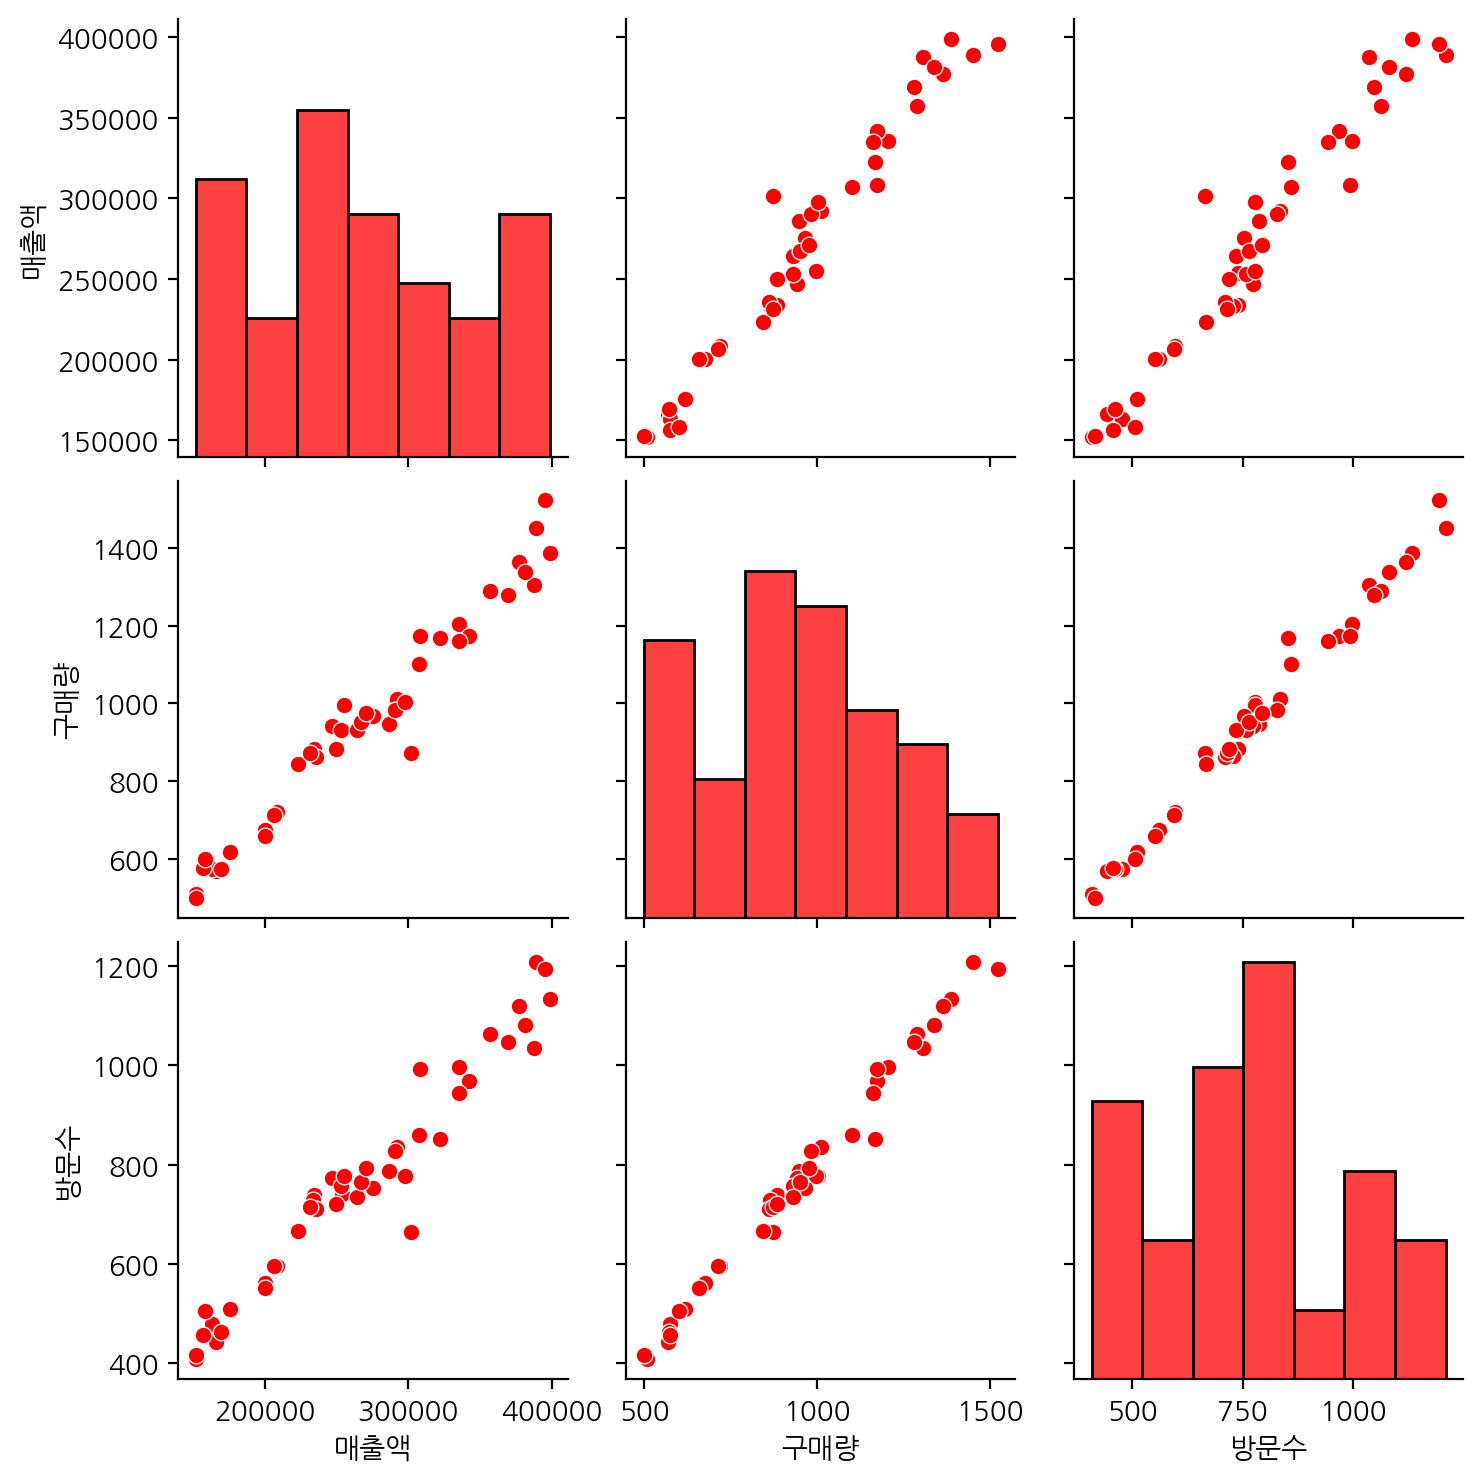

In [116]:
sns.pairplot(vvip_day, diag_kind='hist');

## 전환율
- 전환율은 보통 사용자별로 측정하지 않는다.
- 우리 서비스의 각 스테이지별 전환율을 측정한다.
- 사용자별로 전환율을 측정하는 것이 좋다.
- 사용자수별로 다음 단계로 넘어가는 것을 측정하는 방식으로 측정해보자
- 코호트를 쪼개서 보자
- 전환율을 페이지별로만 그룹해서 보는 것은 무의미할 수도 있다.
- 이 그룹에서는 전환율이 몇이고, 타 그룹에서는 전환율이 몇인지 차이를 확인하여 인사이트를 얻자.
- 다른 변수로 구분된 두 집단의 전환율 등을 구분하는 방식
- 전환되는 그룹과 전환되지 않는 그룹의 차이 확인
- 세그먼트를 나눠보자
- 인구통계(나이, 성별 등), 세션 기간 코호트, 여러 조건을 묶어서 코호트 등
- 특정 이벤트를 한 사람과 안한 사람의 코호트
- 액션 별 코호트
- 최종 목표 : 뷰 - 구매까지
- 특정 액션을 했는지 여부, 특정 액션을 한 시점(언제 첫결제 등)
- 각 스테이지별 전환율을 볼 수 있다
- 전환에 영향을 주는 선행지표를 발견할 수 있다
- 가입시점에 따라 다른다. 특정 이벤트 경험 유무에 따라 다른가. 등
- 이탈 원인 밝히기(추후 사용자 이벤트를 통해 밝혀낼 수 있음)
- 설문이나 리서치
- 우수 고객과 그렇지 않은 고객은 어떤 것이 다른건지 등
- 전체 푸시, 이메일은 보수적으로 사용해야 할 전략
- 타겟팅이 중요

In [117]:
# 평균 세션 시간 코호트당 구매 퍼널 분석
n_samsung

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month,day,md
0,2019-10-01 00:00:11,view,1005011,2053013555631882655,electronics.smartphone,samsung,900.640015,530282093,50a293fb-5940-41b2-baf3-17af0e812101,10,1,10-01
1,2019-10-01 00:00:35,view,3601505,2053013563810775923,appliances.kitchen.washer,samsung,463.149994,526631741,5ec9bd77-beef-443e-b987-62ffb55b8132,10,1,10-01
2,2019-10-01 00:00:36,view,1004767,2053013555631882655,electronics.smartphone,samsung,254.820007,512558158,9a206ba2-37c7-4354-9d31-37ff3bb297ed,10,1,10-01
3,2019-10-01 00:00:55,view,1004659,2053013555631882655,electronics.smartphone,samsung,787.179993,512558158,9a206ba2-37c7-4354-9d31-37ff3bb297ed,10,1,10-01
4,2019-10-01 00:00:57,view,1004873,2053013555631882655,electronics.smartphone,samsung,388.809998,555447651,c3240a5e-6cb8-4d78-9732-a63c608444ef,10,1,10-01
...,...,...,...,...,...,...,...,...,...,...,...,...
13172015,2019-11-30 23:59:47,view,1003911,2053013555631882655,electronics.smartphone,samsung,177.100006,578678977,fc4e8bda-1545-4ed3-aec2-df7805c03d0d,11,30,11-30
13172016,2019-11-30 23:59:50,view,1700652,2053013553031414015,computers.peripherals.monitor,samsung,96.779999,579962208,b12833a5-9770-4527-9dfe-ce6d1fe070c4,11,30,11-30
13172017,2019-11-30 23:59:54,view,1005174,2053013555631882655,electronics.smartphone,samsung,591.750000,579969525,180a7f1f-ed0c-485a-b145-a980716d6abb,11,30,11-30
13172018,2019-11-30 23:59:59,view,1004833,2053013555631882655,electronics.smartphone,samsung,167.029999,557794415,6fecf566-ebb0-4e70-a243-cdc13ce044cb,11,30,11-30


In [118]:
n_samsung.duplicated().sum()

0

In [119]:
session_cohort = n_samsung.groupby(['user_session', 'event_type'])[['event_type']].nunique()
session_cohort

event_type
user_session                         event_type            
00000056-a206-40dd-b174-a072550fa38c cart                 0
                                     purchase             0
                                     view                 1
00000083-8816-4d58-a9b8-f52f54186edc cart                 1
                                     purchase             1
...                                                     ...
fffffbbe-9f76-403b-b17c-e7c68c48ea1c purchase             0
                                     view                 1
fffffd01-5f95-4916-b2dd-491c603d6c9c cart                 1
                                     purchase             1
                                     view                 1

[12832098 rows x 1 columns]

In [120]:
s_cohort = n_samsung.groupby(['user_session', 'event_type']).agg({'event_type':'nunique'})
s_cohort.columns = ['count']
s_cohort

count
user_session                         event_type       
00000056-a206-40dd-b174-a072550fa38c cart            0
                                     purchase        0
                                     view            1
00000083-8816-4d58-a9b8-f52f54186edc cart            1
                                     purchase        1
...                                                ...
fffffbbe-9f76-403b-b17c-e7c68c48ea1c purchase        0
                                     view            1
fffffd01-5f95-4916-b2dd-491c603d6c9c cart            1
                                     purchase        1
                                     view            1

[12832098 rows x 1 columns]

In [121]:
cohort_table = pd.pivot_table(s_cohort, index='user_session', values='count', columns=['event_type'])
cohort_table

event_type,cart,purchase,view
user_session,,,
00000056-a206-40dd-b174-a072550fa38c,0,0,1
00000083-8816-4d58-a9b8-f52f54186edc,1,1,1
000001fd-1f89-45e8-a3ce-fe3218cabfad,1,1,1
000007b4-6d31-4590-b88f-0f68d1cee73c,0,0,1
00000809-9101-4e4b-9795-e6cbafccfe19,0,0,1
...,...,...,...
fffff79f-a682-4f63-ad94-8364fe3d648f,0,0,1
fffff7d0-c21e-4a82-83f1-67685ce6ed1c,0,0,1
fffff956-3426-4d37-9de9-4c00ec4ddeac,0,0,1


In [122]:
cohort_table.columns = ['cart', 'purchase', 'view']
cohort_table = cohort_table[['view', 'cart', 'purchase']]
cohort_table

,view,cart,purchase
user_session,,,
00000056-a206-40dd-b174-a072550fa38c,1,0,0
00000083-8816-4d58-a9b8-f52f54186edc,1,1,1
000001fd-1f89-45e8-a3ce-fe3218cabfad,1,1,1
000007b4-6d31-4590-b88f-0f68d1cee73c,1,0,0
00000809-9101-4e4b-9795-e6cbafccfe19,1,0,0
...,...,...,...
fffff79f-a682-4f63-ad94-8364fe3d648f,1,0,0
fffff7d0-c21e-4a82-83f1-67685ce6ed1c,1,0,0
fffff956-3426-4d37-9de9-4c00ec4ddeac,1,0,0


In [123]:
cohort_table['access'] = 1
cohort_table = cohort_table[['access', 'view', 'cart', 'purchase']]
cohort_table

/var/folders/h1/qk7q5tvs4f55rk_cpsw0m2880000gn/T/ipykernel_24582/1815759552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_table['access'] = 1


,access,view,cart,purchase
user_session,,,,
00000056-a206-40dd-b174-a072550fa38c,1,1,0,0
00000083-8816-4d58-a9b8-f52f54186edc,1,1,1,1
000001fd-1f89-45e8-a3ce-fe3218cabfad,1,1,1,1
000007b4-6d31-4590-b88f-0f68d1cee73c,1,1,0,0
00000809-9101-4e4b-9795-e6cbafccfe19,1,1,0,0
...,...,...,...,...
fffff79f-a682-4f63-ad94-8364fe3d648f,1,1,0,0
fffff7d0-c21e-4a82-83f1-67685ce6ed1c,1,1,0,0
fffff956-3426-4d37-9de9-4c00ec4ddeac,1,1,0,0


In [124]:
cohort_s = cohort_table.copy()

In [125]:
cohort_s['view'] = cohort_s['access'] + cohort_s['view']
cohort_s

,access,view,cart,purchase
user_session,,,,
00000056-a206-40dd-b174-a072550fa38c,1,2,0,0
00000083-8816-4d58-a9b8-f52f54186edc,1,2,1,1
000001fd-1f89-45e8-a3ce-fe3218cabfad,1,2,1,1
000007b4-6d31-4590-b88f-0f68d1cee73c,1,2,0,0
00000809-9101-4e4b-9795-e6cbafccfe19,1,2,0,0
...,...,...,...,...
fffff79f-a682-4f63-ad94-8364fe3d648f,1,2,0,0
fffff7d0-c21e-4a82-83f1-67685ce6ed1c,1,2,0,0
fffff956-3426-4d37-9de9-4c00ec4ddeac,1,2,0,0


In [126]:
cohort_s['cart'] = cohort_s['view'] + cohort_s['cart']
cohort_s

,access,view,cart,purchase
user_session,,,,
00000056-a206-40dd-b174-a072550fa38c,1,2,2,0
00000083-8816-4d58-a9b8-f52f54186edc,1,2,3,1
000001fd-1f89-45e8-a3ce-fe3218cabfad,1,2,3,1
000007b4-6d31-4590-b88f-0f68d1cee73c,1,2,2,0
00000809-9101-4e4b-9795-e6cbafccfe19,1,2,2,0
...,...,...,...,...
fffff79f-a682-4f63-ad94-8364fe3d648f,1,2,2,0
fffff7d0-c21e-4a82-83f1-67685ce6ed1c,1,2,2,0
fffff956-3426-4d37-9de9-4c00ec4ddeac,1,2,2,0


In [127]:
cohort_s['purchase'] = cohort_s['cart'] + cohort_s['purchase']
cohort_s

,access,view,cart,purchase
user_session,,,,
00000056-a206-40dd-b174-a072550fa38c,1,2,2,2
00000083-8816-4d58-a9b8-f52f54186edc,1,2,3,4
000001fd-1f89-45e8-a3ce-fe3218cabfad,1,2,3,4
000007b4-6d31-4590-b88f-0f68d1cee73c,1,2,2,2
00000809-9101-4e4b-9795-e6cbafccfe19,1,2,2,2
...,...,...,...,...
fffff79f-a682-4f63-ad94-8364fe3d648f,1,2,2,2
fffff7d0-c21e-4a82-83f1-67685ce6ed1c,1,2,2,2
fffff956-3426-4d37-9de9-4c00ec4ddeac,1,2,2,2


In [128]:
cohort_s = cohort_s.astype(str)
cohort_s

,access,view,cart,purchase
user_session,,,,
00000056-a206-40dd-b174-a072550fa38c,1,2,2,2
00000083-8816-4d58-a9b8-f52f54186edc,1,2,3,4
000001fd-1f89-45e8-a3ce-fe3218cabfad,1,2,3,4
000007b4-6d31-4590-b88f-0f68d1cee73c,1,2,2,2
00000809-9101-4e4b-9795-e6cbafccfe19,1,2,2,2
...,...,...,...,...
fffff79f-a682-4f63-ad94-8364fe3d648f,1,2,2,2
fffff7d0-c21e-4a82-83f1-67685ce6ed1c,1,2,2,2
fffff956-3426-4d37-9de9-4c00ec4ddeac,1,2,2,2
